In [ ]:
%pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 11.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pla

In [ ]:
# Import necessary libraries
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

In [ ]:
class ShareGPT4VLoader:
    """
    A class for loading and interacting with the ShareGPT4V dataset
    """

    def __init__(self, cache_dir=None):
        """
        Initialize the dataset loader

        Args:
            cache_dir (str, optional): Directory to cache the dataset. Defaults to None.
        """
        self.dataset = load_dataset("Lin-Chen/ShareGPT4V", "ShareGPT4V", cache_dir=cache_dir)
        self.current_split = "train"

    def get_info(self):
        """
        Get basic information about the dataset

        Returns:
            dict: Dataset information
        """
        info = {
            "splits": list(self.dataset.keys()),
            "train_size": len(self.dataset["train"]),
            "features": list(self.dataset["train"].features.keys())
        }

        # Get a sample to analyze its structure
        sample = self.dataset["train"][0]
        if "conversations" in sample:
            # Display the structure of conversations
            conv_sample = sample["conversations"][0] if sample["conversations"] else None
            info["conversation_structure"] = list(conv_sample.keys()) if conv_sample else "Empty"

        return info

    def display_sample(self, idx=0, split="train", max_text_len=100):
        """
        Display a sample from the dataset

        Args:
            idx (int): Index of the sample to display
            split (str): Dataset split to use
            max_text_len (int): Maximum length of text to display

        Returns:
            dict: Sample data
        """
        if split not in self.dataset:
            print(f"Split '{split}' not found. Available splits: {list(self.dataset.keys())}")
            return None

        sample = self.dataset[split][idx]

        # Display basic sample info
        print(f"Sample ID: {sample.get('id', 'N/A')}")
        if "image" in sample:
            print(f"Image path: {sample['image']}")

        # Display conversation
        print("\nConversation:")
        if "conversations" in sample:
            for i, conversation in enumerate(sample["conversations"]):
                # Handle different conversation structures
                if "from" in conversation and "value" in conversation:
                    speaker = conversation["from"]
                    content = conversation["value"]
                elif "role" in conversation and "content" in conversation:
                    speaker = conversation["role"]
                    content = conversation["content"]
                else:
                    print(f"Unknown conversation structure: {conversation.keys()}")
                    continue

                if len(content) > max_text_len:
                    display_content = f"{content[:max_text_len]}..."
                else:
                    display_content = content
                print(f"{speaker}: {display_content}")
        else:
            print("No conversations found in this sample")

        # Display image if available
        if "image" in sample and sample["image"] is not None:
            try:
                # If image is a URL
                if isinstance(sample["image"], str):
                    if sample["image"].startswith("http"):
                        response = requests.get(sample["image"])
                        img = Image.open(BytesIO(response.content))
                    # If image is a local path (likely in the dataset)
                    else:
                        # Try to find the image in the Hugging Face cache
                        try:
                            from huggingface_hub import HfFileSystem
                            fs = HfFileSystem()
                            if fs.exists(f"datasets/Lin-Chen/ShareGPT4V/{sample['image']}"):
                                with fs.open(f"datasets/Lin-Chen/ShareGPT4V/{sample['image']}", "rb") as f:
                                    img = Image.open(BytesIO(f.read()))
                            else:
                                print(f"Image path exists but file not found in HF cache: {sample['image']}")
                                return sample
                        except ImportError:
                            print("Cannot access image directly. Install huggingface_hub for direct access.")
                            return sample

                    plt.figure(figsize=(10, 10))
                    plt.imshow(img)
                    plt.axis('off')
                    plt.title("Image in conversation")
                    plt.show()
                # If image is already a PIL Image or other format
                elif hasattr(sample["image"], "show"):
                    plt.figure(figsize=(10, 10))
                    plt.imshow(sample["image"])
                    plt.axis('off')
                    plt.title("Image in conversation")
                    plt.show()
                else:
                    print(f"Unknown image format: {type(sample['image'])}")
            except Exception as e:
                print(f"Failed to display image: {e}")

        return sample

    def get_sample(self, idx=0, split="train"):
        """
        Get a sample without displaying it

        Args:
            idx (int): Index of the sample to get
            split (str): Dataset split to use

        Returns:
            dict: Sample data
        """
        if split not in self.dataset:
            print(f"Split '{split}' not found. Available splits: {list(self.dataset.keys())}")
            return None

        return self.dataset[split][idx]

    def search_by_keyword(self, keyword, split="train", max_results=5):
        """
        Search for samples containing a specific keyword

        Args:
            keyword (str): Keyword to search for
            split (str): Dataset split to search in
            max_results (int): Maximum number of results to return

        Returns:
            list: List of sample indices containing the keyword
        """
        if split not in self.dataset:
            print(f"Split '{split}' not found. Available splits: {list(self.dataset.keys())}")
            return []

        results = []
        for i, sample in enumerate(self.dataset[split]):
            if "conversations" not in sample:
                continue

            for conv in sample["conversations"]:
                # Check in both possible structures
                content = None
                if "value" in conv:
                    content = conv["value"]
                elif "content" in conv:
                    content = conv["content"]

                if content and keyword.lower() in content.lower():
                    results.append(i)
                    break

            if len(results) >= max_results:
                break

        return results

    def convert_to_dataframe(self, split="train", max_samples=None):
        """
        Convert dataset to pandas DataFrame

        Args:
            split (str): Dataset split to convert
            max_samples (int, optional): Maximum number of samples to include

        Returns:
            pandas.DataFrame: DataFrame containing the dataset
        """
        if split not in self.dataset:
            print(f"Split '{split}' not found. Available splits: {list(self.dataset.keys())}")
            return None

        data = []
        samples_to_process = min(len(self.dataset[split]), max_samples) if max_samples else len(self.dataset[split])

        for i in range(samples_to_process):
            sample = self.dataset[split][i]

            if "conversations" not in sample:
                continue

            human_messages = []
            assistant_messages = []

            for conv in sample["conversations"]:
                # Handle different conversation structures
                if "from" in conv and "value" in conv:
                    if conv["from"] == "human":
                        human_messages.append(conv["value"])
                    elif conv["from"] == "gpt":
                        assistant_messages.append(conv["value"])
                elif "role" in conv and "content" in conv:
                    if conv["role"] == "human" or conv["role"] == "user":
                        human_messages.append(conv["content"])
                    elif conv["role"] == "assistant" or conv["role"] == "gpt":
                        assistant_messages.append(conv["content"])

            sample_id = sample.get("id", str(i))
            has_image = "image" in sample and sample["image"] is not None
            image_path = sample.get("image", None)

            data.append({
                "id": sample_id,
                "human_messages": human_messages,
                "assistant_messages": assistant_messages,
                "has_image": has_image,
                "image_path": image_path
            })

        return pd.DataFrame(data)

    def examine_data_structure(self, num_samples=5, split="train"):
        """
        Examine the structure of the dataset to understand its format

        Args:
            num_samples (int): Number of samples to examine
            split (str): Dataset split to examine

        Returns:
            dict: Information about the dataset structure
        """
        if split not in self.dataset:
            print(f"Split '{split}' not found. Available splits: {list(self.dataset.keys())}")
            return None

        # Check available features
        features = list(self.dataset[split].features.keys())
        print(f"Available features: {features}")

        # Examine conversation structure in multiple samples
        conversation_structures = []
        for i in range(min(num_samples, len(self.dataset[split]))):
            sample = self.dataset[split][i]

            if "conversations" in sample and sample["conversations"]:
                # Get keys in conversation objects
                conv_keys = list(sample["conversations"][0].keys())
                conversation_structures.append(conv_keys)

                # Show an example conversation
                if i == 0:
                    print("\nExample conversation structure:")
                    for j, conv in enumerate(sample["conversations"]):
                        print(f"  Message {j+1}: {conv}")
                        if j >= 1:  # Just show first two messages
                            break

        # Count different structures
        structure_counts = {}
        for struct in conversation_structures:
            struct_key = ", ".join(struct)
            if struct_key in structure_counts:
                structure_counts[struct_key] += 1
            else:
                structure_counts[struct_key] = 1

        print("\nConversation structure frequencies:")
        for struct, count in structure_counts.items():
            print(f"  Structure [{struct}]: {count} samples")

        # Check image paths
        image_path_examples = []
        for i in range(min(num_samples, len(self.dataset[split]))):
            sample = self.dataset[split][i]
            if "image" in sample and sample["image"]:
                image_path_examples.append(sample["image"])

        print("\nImage path examples:")
        for i, path in enumerate(image_path_examples):
            if i >= 3:  # Just show first three paths
                print("  ...")
                break
            print(f"  {path}")

        return {
            "features": features,
            "conversation_structures": conversation_structures,
            "structure_counts": structure_counts,
            "image_path_examples": image_path_examples
        }


In [ ]:
loader = ShareGPT4VLoader()

README.md:   0%|          | 0.00/2.22k [00:00<?, ?B/s]

(…)egpt4v_instruct_gpt4-vision_cap100k.json:   0%|          | 0.00/134M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/102025 [00:00<?, ? examples/s]

In [ ]:
info = loader.get_info()
print("Dataset Information:")
print(f"Available splits: {info['splits']}")
print(f"Train size: {info['train_size']}")
print(f"Features: {info['features']}")


Dataset Information:
Available splits: ['train']
Train size: 102025
Features: ['id', 'image', 'conversations']


In [ ]:
print("\nDisplaying sample 0:")
loader.display_sample(0)


Displaying sample 0:
Sample ID: 000000000009
Image path: coco/train2017/000000000009.jpg

Conversation:
human: What do you see happening in this image?
<image>
gpt: In the center of the image, a vibrant blue lunch tray holds four containers, each brimming with a va...
Image path exists but file not found in HF cache: coco/train2017/000000000009.jpg


{'id': '000000000009',
 'image': 'coco/train2017/000000000009.jpg',
 'conversations': [{'from': 'human',
   'value': 'What do you see happening in this image?\n<image>'},
  {'from': 'gpt',
   'value': "In the center of the image, a vibrant blue lunch tray holds four containers, each brimming with a variety of food items. The containers, two in pink and two in yellow, are arranged in a 2x2 grid.\n\nIn the top left pink container, a slice of bread rests, lightly spread with butter and sprinkled with a handful of almonds. The bread is cut into a rectangle, and the almonds are scattered across its buttery surface.\n\nAdjacent to it in the top right corner, another pink container houses a mix of fruit. Sliced apples with their fresh white interiors exposed share the space with juicy chunks of pineapple. The colors of the apple slices and pineapple chunks contrast beautifully against the pink container.\n\nBelow these, in the bottom left corner of the tray, a yellow container holds a single 

In [ ]:
print("\nSearching for samples with 'image':")
image_samples = loader.search_by_keyword("image")
print(f"Found {len(image_samples)} samples")


Searching for samples with 'image':
Found 5 samples


In [ ]:
# Display the first search result
if image_samples:
    print("\nDisplaying first search result:")
    loader.display_sample(image_samples[0])

# Convert part of the dataset to DataFrame
print("\nConverting to DataFrame (first 10 samples):")
df = loader.convert_to_dataframe()
print(df.head())


Displaying first search result:
Sample ID: 000000000009
Image path: coco/train2017/000000000009.jpg

Conversation:
human: What do you see happening in this image?
<image>
gpt: In the center of the image, a vibrant blue lunch tray holds four containers, each brimming with a va...
Image path exists but file not found in HF cache: coco/train2017/000000000009.jpg

Converting to DataFrame (first 10 samples):
             id                                     human_messages  \
0  000000000009  [What do you see happening in this image?\n<im...   
1  000000000025  [Explain the visual content of the image in gr...   
2  000000000030  [What do you see happening in this image?\n<im...   
3  000000000034  [<image>\nExplain the visual content of the im...   
4  000000000036  [Can you elaborate on the elements of the pict...   

                                  assistant_messages  has_image  \
0  [In the center of the image, a vibrant blue lu...       True   
1  [This image captures a serene mome

In [ ]:
df[df["image_path"].str.contains('coco', case=False)]

,id,human_messages,assistant_messages,has_image,image_path
0,000000000009,[What do you see happening in this image?\n<im...,"[In the center of the image, a vibrant blue lu...",True,coco/train2017/000000000009.jpg
1,000000000025,[Explain the visual content of the image in gr...,[This image captures a serene moment in a zoo ...,True,coco/train2017/000000000025.jpg
2,000000000030,[What do you see happening in this image?\n<im...,"[The image presents a serene garden scene, cen...",True,coco/train2017/000000000030.jpg
3,000000000034,[<image>\nExplain the visual content of the im...,[This is a detailed description of the image:\...,True,coco/train2017/000000000034.jpg
4,000000000036,[Can you elaborate on the elements of the pict...,"[In the image, there is a woman standing in fr...",True,coco/train2017/000000000036.jpg
...,...,...,...,...,...
50022,000000248910,[Describe the following image.\n<image>],"[In this black and white photo, two individual...",True,coco/train2017/000000248910.jpg
50023,000000248911,[<image>\nDescribe the following image.],[In the heart of a medieval jousting tournamen...,True,coco/train2017/000000248911.jpg
50024,000000248912,[Explain the visual content of the image in gr...,"[In the center of the image, a delicious sandw...",True,coco/train2017/000000248912.jpg
50025,000000248918,[What is this photo about'?\n<image>],[The image captures a serene and cozy bedroom ...,True,coco/train2017/000000248918.jpg


In [ ]:
df.size

510125

In [ ]:


def export_to_parquet(sampled_df: pd.DataFrame,file_path: str = "sampled_data.parquet") -> str:
    """Save sampled data to Parquet file"""
    table = pa.Table.from_pandas(sampled_df)
    pq.write_table(table, file_path)
    print(f"Exported sampled data to {file_path}")

    return file_path

def upload_to_catbox(file_path: str) -> str:
    """Upload parquet file to catbox.moe"""
    try:
        with open(file_path, 'rb') as f:
            files = {'fileToUpload': (file_path, f)}
            response = requests.post(
                "https://catbox.moe/user/api.php",
                data={"reqtype": "fileupload"},
                files=files
            )

        if response.status_code == 200:
            url = response.text.strip()
            print(f"Upload success: {url}")
            return url
        else:
            print(f"Upload failed: {response.status_code}")
            return None
    except Exception as e:
        print(f"Upload error: {str(e)}")
        return None

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## WITH PCA

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import requests
import io
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from typing import Optional, Tuple, List
import warnings
warnings.filterwarnings('ignore')

class PCAClusterSampler:
    """
    Enhanced clustering class with spread analysis for optimal cluster selection
    """

    def __init__(self, df: pd.DataFrame, embeddings: Optional[np.ndarray] = None):
        """
        Initialize with a DataFrame, optionally with precomputed embeddings

        Args:
            df (pd.DataFrame): DataFrame containing conversation samples
            embeddings (np.ndarray or None): Precomputed embeddings (optional)
        """
        self.df = df.copy()
        self.original_embeddings = embeddings
        self.embeddings = embeddings
        self.pca_embeddings = None
        self.labels = None
        self.kmeans = None
        self.pca = None
        self.optimal_clusters = None
        self.optimal_components = None
        self.silhouette_scores = {}
        self.cluster_analysis = {}
        self.spread_analysis_results = {}
        self.auto_optimize = False

    def set_embeddings(self, embeddings: np.ndarray):
        """Set custom embeddings manually"""
        self.original_embeddings = embeddings
        self.embeddings = embeddings
        print(f"Set embeddings with shape: {self.embeddings.shape}")

    def embed_texts(self, field: str = "human_messages", encoder=None):
        """Generate embeddings for the text data"""
        if encoder is None:
            raise ValueError("You must provide an encoder function to embed the texts.")

        texts = self.df[field].apply(
            lambda x: " ".join(x) if isinstance(x, list) else str(x)
        ).tolist()

        self.original_embeddings = encoder(texts)
        self.embeddings = self.original_embeddings
        print(f"Generated embeddings for {len(texts)} samples with shape: {self.embeddings.shape}")

    def evaluate_clustering_spreads(self, X, n_clusters):
        """
        Evaluate clustering quality based on silhouette score distribution consistency

        Args:
            X: Feature matrix
            n_clusters: Number of clusters to evaluate

        Returns:
            dict: Comprehensive spread analysis metrics
        """
        # Initialize KMeans with consistent random state
        clusterer = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = clusterer.fit_predict(X)

        # Get silhouette scores
        silhouette_avg = silhouette_score(X, cluster_labels)
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        # Calculate statistics for each cluster
        cluster_stats = []
        cluster_stds = []
        cluster_means = []
        cluster_sizes = []

        for i in range(n_clusters):
            cluster_scores = sample_silhouette_values[cluster_labels == i]
            cluster_std = np.std(cluster_scores)
            cluster_mean = np.mean(cluster_scores)
            cluster_size = len(cluster_scores)

            cluster_stds.append(cluster_std)
            cluster_means.append(cluster_mean)
            cluster_sizes.append(cluster_size)

            cluster_stats.append({
                'cluster_id': i,
                'size': cluster_size,
                'mean_silhouette': cluster_mean,
                'std_silhouette': cluster_std,
                'min_silhouette': np.min(cluster_scores),
                'max_silhouette': np.max(cluster_scores),
                'median_silhouette': np.median(cluster_scores)
            })


        # Calculate spread consistency metrics
        std_of_stds = np.std(cluster_stds)
        mean_of_stds = np.mean(cluster_stds)
        std_of_means = np.std(cluster_means)
        mean_of_means = np.mean(cluster_means)

        # Count outlier clusters (those with spreads significantly different from others)
        outlier_clusters = sum(1 for std in cluster_stds
                              if abs(std - mean_of_stds) > std_of_stds)

        # Calculate coefficient of variation for consistency
        cv_stds = std_of_stds / mean_of_stds if mean_of_stds > 0 else 0
        cv_means = std_of_means / mean_of_means if mean_of_means > 0 else 0

        # Calculate quality score (higher is better)
        # Penalize: high std_of_stds, outlier clusters, low overall silhouette
        # Reward: high overall silhouette, consistent spreads
        consistency_penalty = std_of_stds + (outlier_clusters * 0.1)
        quality_score = silhouette_avg - consistency_penalty

        return {
            'overall_score': silhouette_avg,
            'cluster_stats': cluster_stats,
            'cluster_stds': cluster_stds,
            'cluster_means': cluster_means,
            'cluster_sizes': cluster_sizes,
            'std_of_stds': std_of_stds,
            'mean_of_stds': mean_of_stds,
            'std_of_means': std_of_means,
            'mean_of_means': mean_of_means,
            'outlier_clusters': outlier_clusters,
            'cv_stds': cv_stds,
            'cv_means': cv_means,
            'quality_score': quality_score,
            'clusterer': clusterer
        }

    def find_optimal_clusters_by_spread(self, cluster_range=None):
        """
        Find optimal number of clusters using spread analysis methodology

        Args:
            cluster_range: Range of cluster numbers to test

        Returns:
            tuple: (best_result, all_results)
        """
        if self.pca_embeddings is None:
            raise ValueError("Embeddings not found. Please run .embed_texts() or .set_embeddings() first.")

        if cluster_range is None:
            max_k = min(10, len(self.pca_embeddings) // 10)  # At least 10 samples per cluster
            cluster_range = range(2, max_k + 1)

        results = []

        print("Evaluating clustering spreads...")
        print("=" * 60)
        print("Embeddings Component Dimension", len(self.pca_embeddings))
        for n_clusters in cluster_range:
            metrics = self.evaluate_clustering_spreads(self.pca_embeddings, n_clusters)
            results.append({
                'n_clusters': n_clusters,
                **metrics
            })

            print(f"\nFor n_clusters = {n_clusters}:")
            print(f"Overall silhouette score: {metrics['overall_score']:.3f}")
            print(f"STD of cluster STDs: {metrics['std_of_stds']:.3f}")
            print(f"Mean of cluster STDs: {metrics['mean_of_stds']:.3f}")
            print(f"Individual cluster STDs: {[f'{std:.3f}' for std in metrics['cluster_stds']]}")
            print(f"Number of outlier clusters: {metrics['outlier_clusters']}")
            print(f"Quality score: {metrics['quality_score']:.3f}")

        # Find best configuration using your methodology:
        # 1. Prefer no outlier clusters
        # 2. Lower std_of_stds (more consistent spreads)
        # 3. Higher overall silhouette score
        best_result = min(results, key=lambda x: (
             -x['overall_score'],
            x['outlier_clusters'],
            x['std_of_stds']
        ))

        self.spread_analysis_results = {
            'best_result': best_result,
            'all_results': results
        }

        print("\n" + "=" * 60)
        print("OPTIMAL CLUSTERING FOUND:")
        print(f"Best n_clusters: {best_result['n_clusters']}")
        print(f"Overall silhouette: {best_result['overall_score']:.3f}")
        print(f"STD of cluster STDs: {best_result['std_of_stds']:.3f}")
        print(f"Outlier clusters: {best_result['outlier_clusters']}")
        print("=" * 60)

        return best_result, results

    def plot_spread_analysis(self, results=None):
        """
        Create comprehensive visualization of spread analysis results
        """
        if results is None:
            if not self.spread_analysis_results:
                raise ValueError("Run find_optimal_clusters_by_spread() first")
            results = self.spread_analysis_results['all_results']

        n_clusters_list = [r['n_clusters'] for r in results]
        overall_scores = [r['overall_score'] for r in results]
        std_of_stds = [r['std_of_stds'] for r in results]
        outlier_counts = [r['outlier_clusters'] for r in results]
        quality_scores = [r['quality_score'] for r in results]

        # Create comprehensive plot
        fig = plt.figure(figsize=(20, 15))

        # 1. Overall metrics comparison
        ax1 = plt.subplot(2, 3, 1)
        ax1.plot(n_clusters_list, overall_scores, 'bo-', label='Silhouette Score', linewidth=2)
        ax1_twin = ax1.twinx()
        ax1_twin.plot(n_clusters_list, std_of_stds, 'ro-', label='STD of STDs', linewidth=2)
        ax1.set_xlabel('Number of Clusters')
        ax1.set_ylabel('Overall Silhouette Score', color='blue')
        ax1_twin.set_ylabel('STD of Cluster STDs', color='red')
        ax1.set_title('Overall Metrics vs Number of Clusters')
        ax1.grid(True, alpha=0.3)
        ax1.legend(loc='upper left')
        ax1_twin.legend(loc='upper right')

        # 2. Quality score and outlier clusters
        ax2 = plt.subplot(2, 3, 2)
        bars = ax2.bar(n_clusters_list, quality_scores, alpha=0.7, color='green')
        ax2_twin = ax2.twinx()
        ax2_twin.plot(n_clusters_list, outlier_counts, 'ro-', linewidth=2, markersize=8)

        # Color bars based on outlier count
        for bar, outlier_count in zip(bars, outlier_counts):
            if outlier_count == 0:
                bar.set_color('green')
            elif outlier_count <= 1:
                bar.set_color('orange')
            else:
                bar.set_color('red')

        ax2.set_xlabel('Number of Clusters')
        ax2.set_ylabel('Quality Score', color='green')
        ax2_twin.set_ylabel('Outlier Clusters', color='red')
        ax2.set_title('Quality Score & Outlier Clusters')
        ax2.grid(True, alpha=0.3)

        # 3. Detailed spread analysis for best result
        best_result = min(results, key=lambda x: (-x['overall_score'], x['outlier_clusters'], x['std_of_stds']))
        ax3 = plt.subplot(2, 3, 3)

        cluster_ids = list(range(best_result['n_clusters']))
        cluster_stds = best_result['cluster_stds']
        cluster_means = best_result['cluster_means']

        bars = ax3.bar(cluster_ids, cluster_stds, alpha=0.7)
        ax3.axhline(y=best_result['mean_of_stds'], color='red', linestyle='--',
                   label=f"Mean STD: {best_result['mean_of_stds']:.3f}")
        ax3.axhline(y=best_result['mean_of_stds'] + best_result['std_of_stds'],
                   color='orange', linestyle=':', alpha=0.7)
        ax3.axhline(y=best_result['mean_of_stds'] - best_result['std_of_stds'],
                   color='orange', linestyle=':', alpha=0.7)

        ax3.set_xlabel('Cluster ID')
        ax3.set_ylabel('Silhouette STD')
        ax3.set_title(f'Cluster Spread Consistency\n(Best: k={best_result["n_clusters"]})')
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        # 4. Silhouette distribution for best clustering
        ax4 = plt.subplot(2, 3, 4)
        X = self.pca_embeddings
        clusterer = best_result['clusterer']
        cluster_labels = clusterer.labels_
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        colors = cm.nipy_spectral(np.linspace(0, 1, best_result['n_clusters']))

        for i, color in enumerate(colors):
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            ax4.fill_betweenx(np.arange(y_lower, y_upper), 0,
                             ith_cluster_silhouette_values,
                             facecolor=color, edgecolor=color, alpha=0.7)

            ax4.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        ax4.axvline(x=best_result['overall_score'], color="red", linestyle="--")
        ax4.set_xlabel('Silhouette Coefficient Values')
        ax4.set_ylabel('Cluster Label')
        ax4.set_title(f'Silhouette Analysis\n(k={best_result["n_clusters"]})')

        # 5. Comparison table of top candidates
        ax5 = plt.subplot(2, 3, 5)
        ax5.axis('tight')
        ax5.axis('off')

        # Sort results by quality
        sorted_results = sorted(results, key=lambda x: (x['outlier_clusters'], x['std_of_stds'], -x['overall_score']))
        top_5 = sorted_results[:5]

        table_data = []
        for r in top_5:
            table_data.append([
                r['n_clusters'],
                f"{r['overall_score']:.3f}",
                f"{r['std_of_stds']:.3f}",
                r['outlier_clusters'],
                f"{r['quality_score']:.3f}"
            ])

        table = ax5.table(cellText=table_data,
                         colLabels=['k', 'Silhouette', 'STD of STDs', 'Outliers', 'Quality'],
                         cellLoc='center',
                         loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 1.5)
        ax5.set_title('Top 5 Clustering Configurations')

        # 6. Individual cluster statistics for best result
        ax6 = plt.subplot(2, 3, 6)

        cluster_stats = best_result['cluster_stats']
        cluster_ids = [stat['cluster_id'] for stat in cluster_stats]
        cluster_means = [stat['mean_silhouette'] for stat in cluster_stats]
        cluster_stds = [stat['std_silhouette'] for stat in cluster_stats]

        ax6.errorbar(cluster_ids, cluster_means, yerr=cluster_stds,
                    fmt='o-', capsize=5, capthick=2, linewidth=2, markersize=8)
        ax6.set_xlabel('Cluster ID')
        ax6.set_ylabel('Mean Silhouette ± STD')
        ax6.set_title('Per-Cluster Silhouette Statistics')
        ax6.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Print detailed statistics
        self._print_detailed_spread_analysis(best_result)

    def _print_detailed_spread_analysis(self, best_result):
        """Print comprehensive analysis of the best clustering result"""
        print("\n" + "="*80)
        print("DETAILED SPREAD ANALYSIS REPORT")
        print("="*80)

        print(f"\nOPTIMAL CONFIGURATION:")
        print(f"Number of clusters: {best_result['n_clusters']}")
        print(f"Overall silhouette score: {best_result['overall_score']:.4f}")
        print(f"Quality score: {best_result['quality_score']:.4f}")

        print(f"\nSPREAD CONSISTENCY METRICS:")
        print(f"STD of cluster STDs: {best_result['std_of_stds']:.4f}")
        print(f"Mean of cluster STDs: {best_result['mean_of_stds']:.4f}")
        print(f"Coefficient of variation (STDs): {best_result['cv_stds']:.4f}")
        print(f"Number of outlier clusters: {best_result['outlier_clusters']}")

        print(f"\nPER-CLUSTER DETAILED STATISTICS:")
        print("-" * 80)
        print(f"{'ID':<3} {'Size':<6} {'Mean':<8} {'STD':<8} {'Min':<8} {'Max':<8} {'Median':<8}")
        print("-" * 80)

        for stat in best_result['cluster_stats']:
            print(f"{stat['cluster_id']:<3} "
                  f"{stat['size']:<6} "
                  f"{stat['mean_silhouette']:<8.3f} "
                  f"{stat['std_silhouette']:<8.3f} "
                  f"{stat['min_silhouette']:<8.3f} "
                  f"{stat['max_silhouette']:<8.3f} "
                  f"{stat['median_silhouette']:<8.3f}")

        print("="*80)

    def cluster(self, n_clusters: int = None, random_state: int = 42,
                auto_optimize: bool = False, use_spread_analysis: bool = False):
        """
        Perform clustering using KMeans

        Args:
            n_clusters (int): Number of clusters (if None and auto_optimize=True, will find optimal)
            random_state (int): Random state for reproducibility
            auto_optimize (bool): Whether to auto-optimize using traditional methods
            use_spread_analysis (bool): Whether to use spread analysis for optimization
        """
        if self.embeddings is None:
            raise ValueError("Embeddings not found. Please run .embed_texts() or .set_embeddings() first.")

        self.auto_optimize = auto_optimize or use_spread_analysis

        # Determine number of clusters
        if use_spread_analysis:
            if self.embeddings.shape[1] > 10:
                      print("High-dimensional embeddings detected. Applying PCA optimization...")
                      self.find_optimal_pca_components()
                      self.apply_pca()
            print("Using spread analysis for cluster optimization...")
            best_result, _ = self.find_optimal_clusters_by_spread()
            n_clusters = best_result['n_clusters']
            self.kmeans = best_result['clusterer']
            self.labels = self.kmeans.labels_
        else:
            # Traditional optimization if requested
            if auto_optimize and n_clusters is None:
                print("Auto-optimization enabled. Finding optimal parameters...")

                # Find optimal PCA components if embeddings are high-dimensional
                if self.embeddings.shape[1] > 10:
                    print("High-dimensional embeddings detected. Applying PCA optimization...")
                    self.find_optimal_pca_components()
                    self.apply_pca()

                # Find optimal clusters using traditional silhouette method
                print("Finding optimal number of clusters...")
                n_clusters = self.find_optimal_clusters()

            if n_clusters is None:
                n_clusters = 5  # Default fallback

            self.kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
            self.labels = self.kmeans.fit_predict(self.pca_embeddings)

        # Update DataFrame with cluster labels
        self.df['cluster'] = self.labels

        # Store cluster analysis
        self.cluster_analysis = {
            'n_clusters': n_clusters,
            'silhouette_score': silhouette_score(self.pca_embeddings, self.labels),
            'cluster_sizes': np.bincount(self.labels),
            'cluster_centers': self.kmeans.cluster_centers_
        }

        print(f"Assigned cluster labels to {len(self.df)} samples")
        print(f"Silhouette Score: {self.cluster_analysis['silhouette_score']:.4f}")

        # Show detailed analysis if requested
        if use_spread_analysis:
            print("\nDetailed spread analysis:")
            self.plot_spread_analysis()
        elif auto_optimize:
            print("\nDetailed traditional analysis:")
            self.plot_detailed_silhouette_analysis()

    # ... (keeping all other existing methods unchanged)
    def find_optimal_pca_components(self, max_components: Optional[int] = None,
                                  variance_threshold: float = 0.95) -> int:
        """Find optimal number of PCA components using elbow method and variance threshold"""
        if self.embeddings is None:
            raise ValueError("Embeddings not found. Please run .embed_texts() or .set_embeddings() first.")

        n_samples, n_features = self.embeddings.shape
        max_comp = min(n_samples, n_features) if max_components is None else max_components
        max_comp = min(max_comp, min(n_samples, n_features))

        components_range = range(1, min(max_comp + 1, 51))
        explained_variance_ratios = []
        cumulative_variance = []

        for n_comp in components_range:
            pca_temp = PCA(n_components=n_comp, random_state=42)
            pca_temp.fit(self.embeddings)
            explained_variance_ratios.append(pca_temp.explained_variance_ratio_)
            cumulative_variance.append(np.sum(pca_temp.explained_variance_ratio_))

        if len(cumulative_variance) > 2:
            second_derivative = np.diff(cumulative_variance, 2)
            elbow_point = np.argmax(second_derivative) + 2
        else:
            elbow_point = len(cumulative_variance)

        variance_point = next((i for i, var in enumerate(cumulative_variance)
                             if var >= variance_threshold), len(cumulative_variance))

        optimal_components = min(elbow_point, variance_point) + 1
        optimal_components = max(2, optimal_components)

        self.optimal_components = optimal_components
        print(f"Optimal number of PCA components: {optimal_components}")
        print(f"Cumulative variance explained: {cumulative_variance[optimal_components-1]:.4f}")

        return optimal_components

    def apply_pca(self, n_components: Optional[int] = None):
        """Apply PCA to reduce dimensionality"""
        if self.embeddings is None:
            raise ValueError("Embeddings not found. Please run .embed_texts() or .set_embeddings() first.")

        if n_components is None:
            if self.optimal_components is None:
                n_components = self.find_optimal_pca_components()
            else:
                n_components = self.optimal_components

        self.pca = PCA(n_components=n_components, random_state=42)
        self.pca_embeddings = self.pca.fit_transform(self.embeddings)
        self.embeddings = self.pca_embeddings

        print(f"Applied PCA: {self.original_embeddings.shape} -> {self.pca_embeddings.shape}")
        print(f"Explained variance ratio: {self.pca.explained_variance_ratio_.sum():.4f}")

    def find_optimal_clusters(self, k_range: Optional[List[int]] = None,
                            silhouette_threshold: float = 0.5) -> int:
        # print(len(self.pca_embeddings))
        """Find optimal number of clusters using traditional silhouette analysis"""
        if self.embeddings is None:
            raise ValueError("Embeddings not found. Please run .embed_texts() or .set_embeddings() first.")

        if k_range is None:
            max_k = min(10, len(self.pca_embeddings) // 10)
            k_range = list(range(2, max_k + 1))

        silhouette_scores = []
        print("K RANGE :", k_range)
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42)
            labels = kmeans.fit_predict(self.pca_embeddings)
            sil_score = silhouette_score(self.pca_embeddings, labels)
            silhouette_scores.append(sil_score)
            self.silhouette_scores[k] = sil_score
            print(f"k={k}: Silhouette Score = {sil_score:.4f}")

        valid_k = [k for k, score in zip(k_range, silhouette_scores)
                  if score >= silhouette_threshold]

        if not valid_k:
            print(f"Warning: No clusters meet silhouette threshold of {silhouette_threshold}")
            optimal_k = k_range[np.argmax(silhouette_scores)]
        else:
            valid_scores = [self.silhouette_scores[k] for k in valid_k]
            optimal_k = valid_k[np.argmax(valid_scores)]

        self.optimal_clusters = optimal_k
        print(f"Optimal number of clusters: {optimal_k}")
        print(f"Silhouette score: {self.silhouette_scores[optimal_k]:.4f}")

        return optimal_k

    def plot_detailed_silhouette_analysis(self):
        """Create detailed silhouette analysis plots"""
        if self.labels is None or self.embeddings is None:
            raise ValueError("You must run .cluster() first before plotting.")

        n_clusters = len(np.unique(self.labels))
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(self.pca_embeddings) + (n_clusters + 1) * 10])

        sample_silhouette_values = silhouette_samples(self.pca_embeddings, self.labels)
        silhouette_avg = self.cluster_analysis['silhouette_score']

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[self.labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper), 0,
                             ith_cluster_silhouette_values,
                             facecolor=color, edgecolor=color, alpha=0.7)

            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        ax1.set_title("Silhouette Plot for Various Clusters")
        ax1.set_xlabel("Silhouette Coefficient Values")
        ax1.set_ylabel("Cluster Label")
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        # 2D visualization
        if self.pca_embeddings.shape[1] == 2:
            scatter_x, scatter_y = self.pca_embeddings[:, 0], self.pca_embeddings[:, 1]
        else:
            pca_2d = PCA(n_components=2, random_state=42)
            embeddings_2d = pca_2d.fit_transform(self.pca_embeddings)
            scatter_x, scatter_y = embeddings_2d[:, 0], embeddings_2d[:, 1]

        colors = cm.nipy_spectral(self.labels.astype(float) / n_clusters)
        ax2.scatter(scatter_x, scatter_y, marker=".", s=30, lw=0, alpha=0.7,
                   c=colors, edgecolor="k")

        ax2.set_title("Visualization of Clustered Data")
        ax2.set_xlabel("Feature Space (1st Component)")
        ax2.set_ylabel("Feature Space (2nd Component)")

        plt.tight_layout()
        plt.show()

    def sample_from_clusters(self, samples_per_cluster: int = 10,
                           strategy: str = 'random') -> pd.DataFrame:
        """Sample items from each cluster"""
        if self.labels is None:
            raise ValueError("You must run .cluster() first before sampling.")

        sampled_frames = []

        for cluster_id in np.unique(self.labels):
            cluster_df = self.df[self.df['cluster'] == cluster_id]
            cluster_embeddings = self.pca_embeddings[self.labels == cluster_id]

            n_samples = min(samples_per_cluster, len(cluster_df))

            if strategy == 'random':
                sampled = cluster_df.sample(n=n_samples, random_state=42)
            elif strategy == 'representative':
                center = self.kmeans.cluster_centers_[cluster_id]
                distances = np.linalg.norm(cluster_embeddings - center, axis=1)
                closest_indices = np.argsort(distances)[:n_samples]
                sampled = cluster_df.iloc[closest_indices]
            else:
                raise ValueError("Strategy must be 'random' or 'representative'")

            sampled_frames.append(sampled)
            print(f"Sampled {len(sampled)} items from cluster {cluster_id}")

        return pd.concat(sampled_frames).reset_index(drop=True)

    def export_to_parquet(self, sampled_df: pd.DataFrame,
                         file_path: str = "sampled_data.parquet") -> str:
        """Save sampled data to Parquet file"""
        table = pa.Table.from_pandas(sampled_df)
        pq.write_table(table, file_path)
        print(f"Exported sampled data to {file_path}")
        return file_path

    def upload_to_catbox(self, file_path: str) -> Optional[str]:
        """Upload parquet file to catbox.moe"""
        try:
            with open(file_path, 'rb') as f:
                files = {'fileToUpload': (file_path, f)}
                response = requests.post(
                    "https://catbox.moe/user/api.php",
                    data={"reqtype": "fileupload"},
                    files=files
                )

            if response.status_code == 200:
                url = response.text.strip()
                print(f"Upload success: {url}")
                return url
            else:
                print(f"Upload failed: {response.status_code}")
                return None
        except Exception as e:
            print(f"Upload error: {str(e)}")
            return None

    def get_cluster_summary(self) -> dict:
        """Get comprehensive cluster analysis summary"""
        if self.cluster_analysis is None:
            raise ValueError("You must run .cluster() first.")

        summary = {
            'clustering': self.cluster_analysis,
            'pca': {
                'n_components': self.optimal_components,
                'explained_variance_ratio': self.pca.explained_variance_ratio_.sum() if self.pca else None
            },
            'optimization': {
                'silhouette_scores': self.silhouette_scores,
                'optimal_clusters': self.optimal_clusters
            }
        }

        # Add spread analysis results if available
        if self.spread_analysis_results:
            summary['spread_analysis'] = self.spread_analysis_results

        return summary

In [ ]:
PCASampler = PCAClusterSampler(df[df["image_path"].str.contains('coco', case=False)])

In [ ]:
PCASampler.embed_texts(field="human_messages", encoder=model.encode)

Generated embeddings for 50027 samples with shape: (50027, 384)


In [ ]:
PCASampler.embeddings

array([[-0.03888726,  0.10166974,  0.01050493, ...,  0.02047086,
        -0.0406801 ,  0.02504838],
       [ 0.00712499,  0.12115155, -0.00509342, ...,  0.12637495,
         0.01581883, -0.0024455 ],
       [-0.03888726,  0.10166974,  0.01050493, ...,  0.02047086,
        -0.0406801 ,  0.02504838],
       ...,
       [ 0.00712499,  0.12115155, -0.00509342, ...,  0.12637495,
         0.01581883, -0.0024455 ],
       [-0.07787257,  0.15418804,  0.00897816, ...,  0.06742392,
        -0.05403718,  0.00625895],
       [-0.05871787,  0.08682252,  0.06393955, ..., -0.06393833,
        -0.07834172,  0.08819329]], dtype=float32)

In [ ]:
PCASampler.embeddings.shape

(50027, 384)

High-dimensional embeddings detected. Applying PCA optimization...
Optimal number of PCA components: 10
Cumulative variance explained: 0.9581
Applied PCA: (50027, 384) -> (50027, 10)
Explained variance ratio: 0.9581
Using spread analysis for cluster optimization...
Evaluating clustering spreads...
Embeddings Component Dimension 50027

For n_clusters = 2:
Overall silhouette score: 0.238
STD of cluster STDs: 0.018
Mean of cluster STDs: 0.082
Individual cluster STDs: ['0.065', '0.100']
Number of outlier clusters: 0
Quality score: 0.220

For n_clusters = 3:
Overall silhouette score: 0.303
STD of cluster STDs: 0.026
Mean of cluster STDs: 0.035
Individual cluster STDs: ['0.001', '0.063', '0.040']
Number of outlier clusters: 2
Quality score: 0.077

For n_clusters = 4:
Overall silhouette score: 0.347
STD of cluster STDs: 0.022
Mean of cluster STDs: 0.024
Individual cluster STDs: ['0.002', '0.058', '0.006', '0.029']
Number of outlier clusters: 1
Quality score: 0.225

OPTIMAL CLUSTERING FOUND:
B

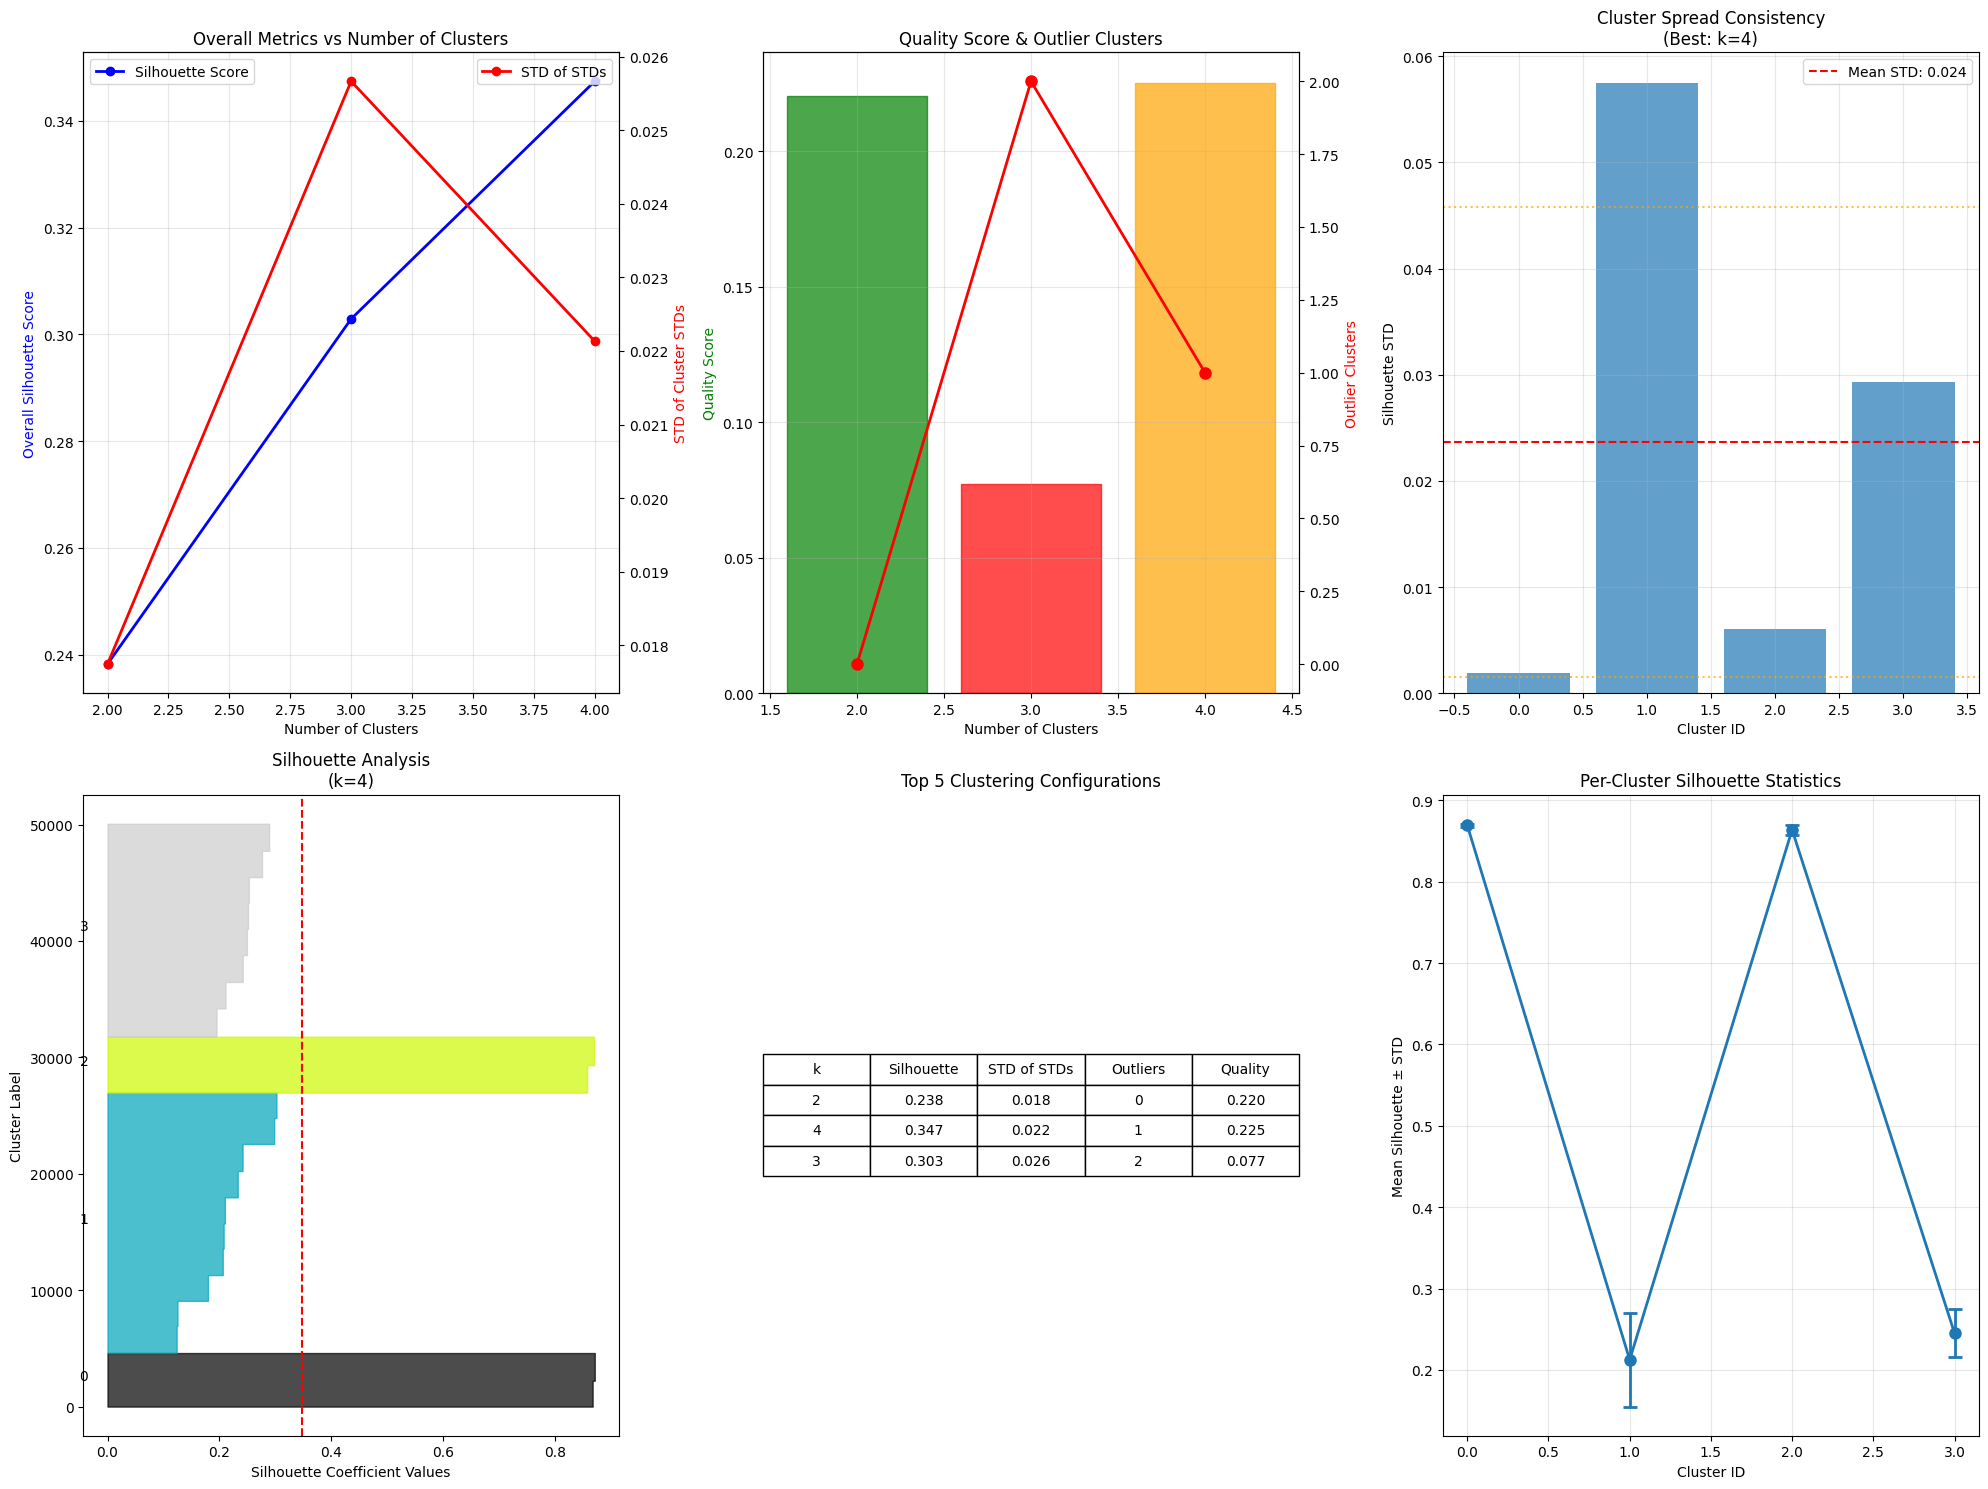


DETAILED SPREAD ANALYSIS REPORT

OPTIMAL CONFIGURATION:
Number of clusters: 4
Overall silhouette score: 0.3474
Quality score: 0.2253

SPREAD CONSISTENCY METRICS:
STD of cluster STDs: 0.0221
Mean of cluster STDs: 0.0237
Coefficient of variation (STDs): 0.9343
Number of outlier clusters: 1

PER-CLUSTER DETAILED STATISTICS:
--------------------------------------------------------------------------------
ID  Size   Mean     STD      Min      Max      Median  
--------------------------------------------------------------------------------
0   4600   0.869    0.002    0.867    0.871    0.871   
1   22345  0.212    0.058    0.124    0.302    0.210   
2   4803   0.864    0.006    0.858    0.870    0.870   
3   18279  0.245    0.029    0.195    0.289    0.249   


In [ ]:
PCASampler.cluster(use_spread_analysis=True)

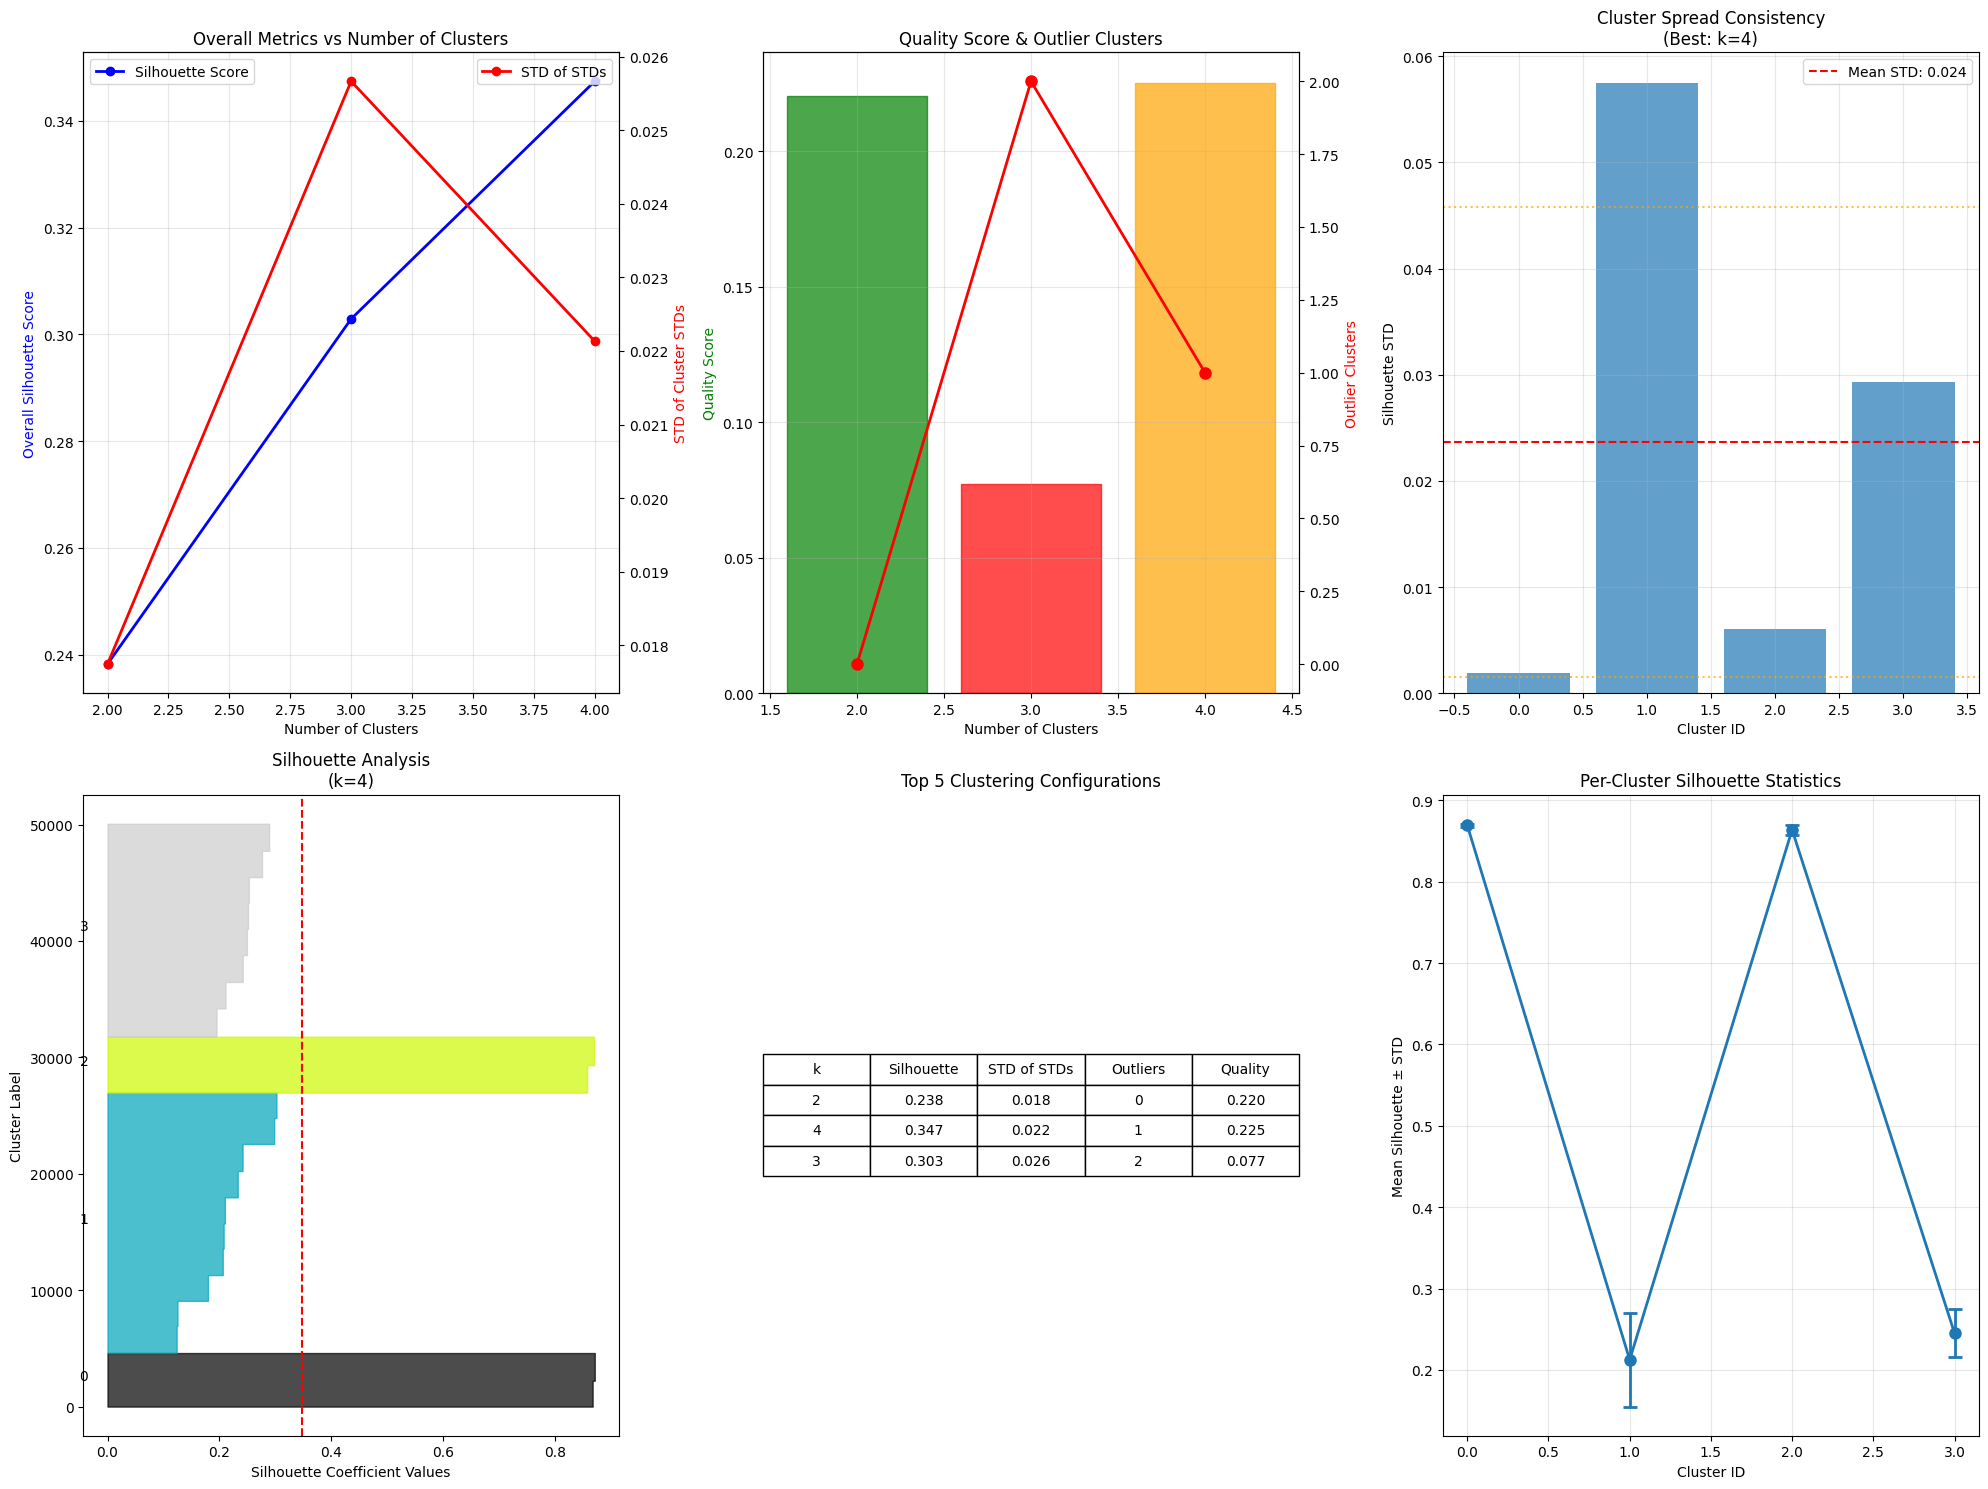


DETAILED SPREAD ANALYSIS REPORT

OPTIMAL CONFIGURATION:
Number of clusters: 4
Overall silhouette score: 0.3474
Quality score: 0.2253

SPREAD CONSISTENCY METRICS:
STD of cluster STDs: 0.0221
Mean of cluster STDs: 0.0237
Coefficient of variation (STDs): 0.9343
Number of outlier clusters: 1

PER-CLUSTER DETAILED STATISTICS:
--------------------------------------------------------------------------------
ID  Size   Mean     STD      Min      Max      Median  
--------------------------------------------------------------------------------
0   4600   0.869    0.002    0.867    0.871    0.871   
1   22345  0.212    0.058    0.124    0.302    0.210   
2   4803   0.864    0.006    0.858    0.870    0.870   
3   18279  0.245    0.029    0.195    0.289    0.249   


In [ ]:
PCASampler.plot_spread_analysis()

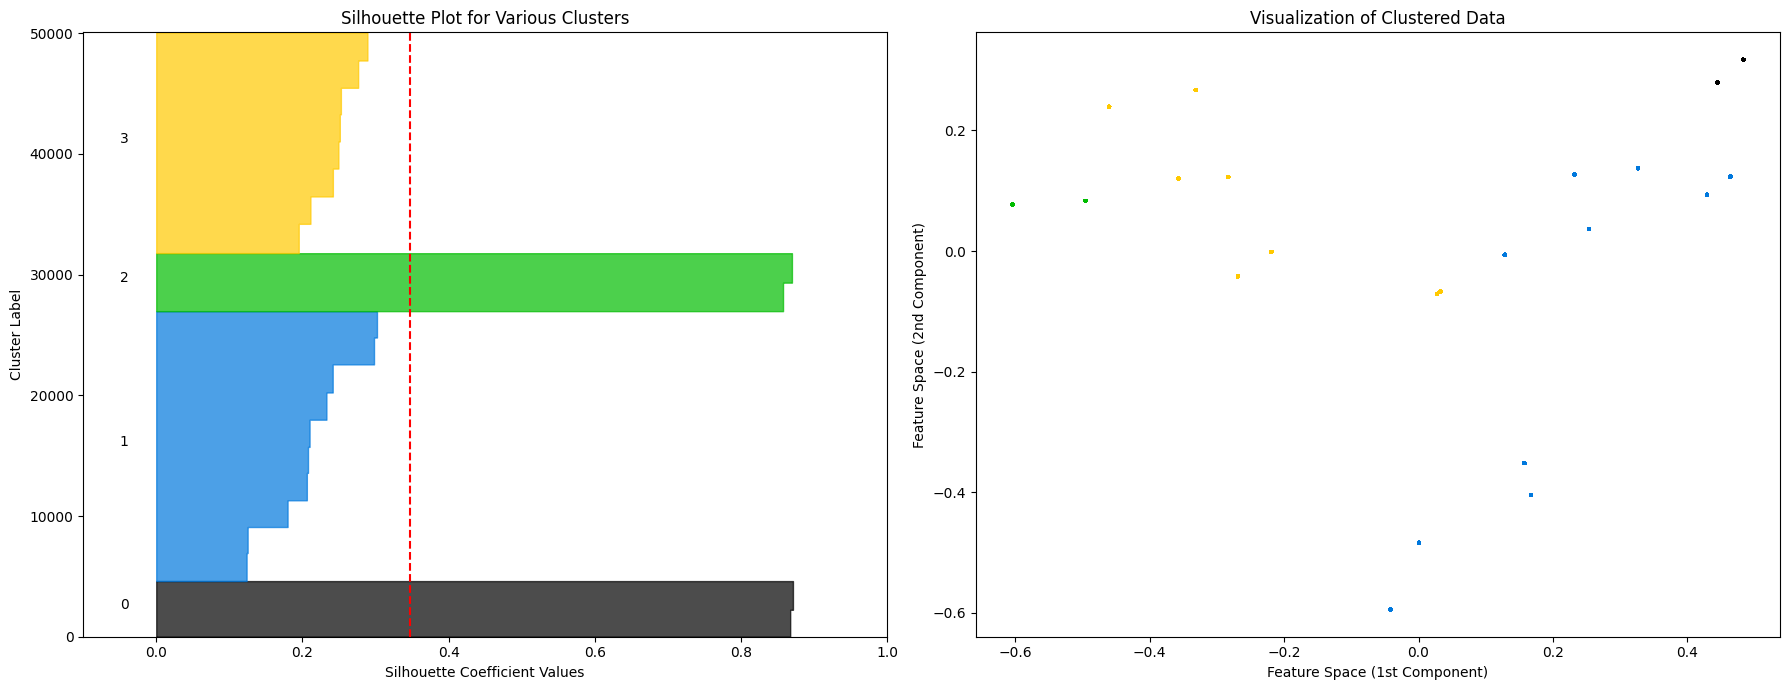

In [ ]:
PCASampler.plot_detailed_silhouette_analysis()

In [ ]:
best_result, all_results = PCASampler.find_optimal_clusters_by_spread()

In [ ]:
PCASampler.plot_spread_analysis()

In [ ]:
# Method 3: Traditional clustering with your optimal k
PCASampler.cluster(n_clusters=best_result['n_clusters'])

In [ ]:
PCAsampled_df = PCASampler.sample_from_clusters(samples_per_cluster=5000, strategy='representative')

In [ ]:
PCAsummary = PCASampler.get_cluster_summary()
print(PCAsummary)

## With UMAP

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import umap
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import requests
import io
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from typing import Optional, Tuple, List
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from sklearn.manifold import trustworthiness
import matplotlib.pyplot as plt

def find_elbow_point(components_range, trustworthiness_scores):
    """
    Find elbow point using the maximum curvature method
    """
    if len(components_range) < 3:
        return components_range[0]

    # Calculate second derivatives (curvature)
    curvatures = []
    for i in range(1, len(trustworthiness_scores) - 1):
        curvature = trustworthiness_scores[i-1] - 2*trustworthiness_scores[i] + trustworthiness_scores[i+1]
        curvatures.append(abs(curvature))

    # Find the point with maximum curvature
    if curvatures:
        elbow_idx = np.argmax(curvatures) + 1  # +1 because curvatures start from index 1
        return components_range[elbow_idx]
    else:
        return components_range[0]


class UMAPClusterSampler:
    """
    Enhanced clustering class with UMAP dimensionality reduction and spread analysis for optimal cluster selection
    """

    def __init__(self, df: pd.DataFrame, embeddings: Optional[np.ndarray] = None):
        """
        Initialize with a DataFrame, optionally with precomputed embeddings

        Args:
            df (pd.DataFrame): DataFrame containing conversation samples
            embeddings (np.ndarray or None): Precomputed embeddings (optional)
        """
        self.df = df.copy()
        self.original_embeddings = embeddings
        self.embeddings = embeddings
        self.umap_embeddings = None
        self.labels = None
        self.kmeans = None
        self.umap_reducer = None
        self.optimal_clusters = None
        self.optimal_components = None
        self.silhouette_scores = {}
        self.cluster_analysis = {}
        self.spread_analysis_results = {}
        self.auto_optimize = False

    def set_embeddings(self, embeddings: np.ndarray):
        """Set custom embeddings manually"""
        self.original_embeddings = embeddings
        self.embeddings = embeddings
        print(f"Set embeddings with shape: {self.embeddings.shape}")

    def embed_texts(self, field: str = "human_messages", encoder=None):
        """Generate embeddings for the text data"""
        if encoder is None:
            raise ValueError("You must provide an encoder function to embed the texts.")

        texts = self.df[field].apply(
            lambda x: " ".join(x) if isinstance(x, list) else str(x)
        ).tolist()

        self.original_embeddings = encoder(texts)
        self.embeddings = self.original_embeddings
        print(f"Generated embeddings for {len(texts)} samples with shape: {self.embeddings.shape}")

    def evaluate_clustering_spreads(self, X, n_clusters):
        """
        Evaluate clustering quality based on silhouette score distribution consistency

        Args:
            X: Feature matrix
            n_clusters: Number of clusters to evaluate

        Returns:
            dict: Comprehensive spread analysis metrics
        """
        # Initialize KMeans with consistent random state
        clusterer = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = clusterer.fit_predict(X)

        # Get silhouette scores
        silhouette_avg = silhouette_score(X, cluster_labels)
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        # Calculate statistics for each cluster
        cluster_stats = []
        cluster_stds = []
        cluster_means = []
        cluster_sizes = []

        for i in range(n_clusters):
            cluster_scores = sample_silhouette_values[cluster_labels == i]
            cluster_std = np.std(cluster_scores)
            cluster_mean = np.mean(cluster_scores)
            cluster_size = len(cluster_scores)

            cluster_stds.append(cluster_std)
            cluster_means.append(cluster_mean)
            cluster_sizes.append(cluster_size)

            cluster_stats.append({
                'cluster_id': i,
                'size': cluster_size,
                'mean_silhouette': cluster_mean,
                'std_silhouette': cluster_std,
                'min_silhouette': np.min(cluster_scores),
                'max_silhouette': np.max(cluster_scores),
                'median_silhouette': np.median(cluster_scores)
            })

        # Calculate spread consistency metrics
        std_of_stds = np.std(cluster_stds)
        mean_of_stds = np.mean(cluster_stds)
        std_of_means = np.std(cluster_means)
        mean_of_means = np.mean(cluster_means)

        # Count outlier clusters (those with spreads significantly different from others)
        outlier_clusters = sum(1 for std in cluster_stds
                              if abs(std - mean_of_stds) > std_of_stds)

        # Calculate coefficient of variation for consistency
        cv_stds = std_of_stds / mean_of_stds if mean_of_stds > 0 else 0
        cv_means = std_of_means / mean_of_means if mean_of_means > 0 else 0

        # Calculate quality score (higher is better)
        consistency_penalty = std_of_stds + (outlier_clusters * 0.1)
        quality_score = silhouette_avg - consistency_penalty

        return {
            'overall_score': silhouette_avg,
            'cluster_stats': cluster_stats,
            'cluster_stds': cluster_stds,
            'cluster_means': cluster_means,
            'cluster_sizes': cluster_sizes,
            'std_of_stds': std_of_stds,
            'mean_of_stds': mean_of_stds,
            'std_of_means': std_of_means,
            'mean_of_means': mean_of_means,
            'outlier_clusters': outlier_clusters,
            'cv_stds': cv_stds,
            'cv_means': cv_means,
            'quality_score': quality_score,
            'clusterer': clusterer
        }

    def find_optimal_clusters_by_spread(self, cluster_range=None, max_cluster_range: int = 10):
        """
        Find optimal number of clusters using spread analysis methodology

        Args:
            cluster_range: Range of cluster numbers to test

        Returns:
            tuple: (best_result, all_results)
        """
        if self.umap_embeddings is None:
            raise ValueError("UMAP embeddings not found. Please run .embed_texts() or .set_embeddings() first.")

        if cluster_range is None:
            max_k = min(max_cluster_range, len(self.umap_embeddings) // 10)  # At least 10 samples per cluster
            cluster_range = range(2, max_k + 1)

        results = []

        print("Evaluating clustering spreads...")
        print("=" * 60)
        print("UMAP Embeddings Component Dimension", len(self.umap_embeddings))
        for n_clusters in cluster_range:
            metrics = self.evaluate_clustering_spreads(self.umap_embeddings, n_clusters)
            results.append({
                'n_clusters': n_clusters,
                **metrics
            })

            print(f"\nFor n_clusters = {n_clusters}:")
            print(f"Overall silhouette score: {metrics['overall_score']:.3f}")
            print(f"STD of cluster STDs: {metrics['std_of_stds']:.3f}")
            print(f"Mean of cluster STDs: {metrics['mean_of_stds']:.3f}")
            print(f"Individual cluster STDs: {[f'{std:.3f}' for std in metrics['cluster_stds']]}")
            print(f"Number of outlier clusters: {metrics['outlier_clusters']}")
            print(f"Quality score: {metrics['quality_score']:.3f}")

        # Find best configuration
        best_result = min(results, key=lambda x: (
            -x['overall_score'],
            x['outlier_clusters'],
            x['std_of_stds']
        ))

        self.spread_analysis_results = {
            'best_result': best_result,
            'all_results': results
        }

        print("\n" + "=" * 60)
        print("OPTIMAL CLUSTERING FOUND:")
        print(f"Best n_clusters: {best_result['n_clusters']}")
        print(f"Overall silhouette: {best_result['overall_score']:.3f}")
        print(f"STD of cluster STDs: {best_result['std_of_stds']:.3f}")
        print(f"Outlier clusters: {best_result['outlier_clusters']}")
        print("=" * 60)

        return best_result, results

    def plot_spread_analysis(self, results=None):
        """
        Create comprehensive visualization of spread analysis results
        """
        if results is None:
            if not self.spread_analysis_results:
                raise ValueError("Run find_optimal_clusters_by_spread() first")
            results = self.spread_analysis_results['all_results']

        n_clusters_list = [r['n_clusters'] for r in results]
        overall_scores = [r['overall_score'] for r in results]
        std_of_stds = [r['std_of_stds'] for r in results]
        outlier_counts = [r['outlier_clusters'] for r in results]
        quality_scores = [r['quality_score'] for r in results]

        # Create comprehensive plot
        fig = plt.figure(figsize=(20, 15))

        # 1. Overall metrics comparison
        ax1 = plt.subplot(2, 3, 1)
        ax1.plot(n_clusters_list, overall_scores, 'bo-', label='Silhouette Score', linewidth=2)
        ax1_twin = ax1.twinx()
        ax1_twin.plot(n_clusters_list, std_of_stds, 'ro-', label='STD of STDs', linewidth=2)
        ax1.set_xlabel('Number of Clusters')
        ax1.set_ylabel('Overall Silhouette Score', color='blue')
        ax1_twin.set_ylabel('STD of Cluster STDs', color='red')
        ax1.set_title('Overall Metrics vs Number of Clusters')
        ax1.grid(True, alpha=0.3)
        ax1.legend(loc='upper left')
        ax1_twin.legend(loc='upper right')

        # 2. Quality score and outlier clusters
        ax2 = plt.subplot(2, 3, 2)
        bars = ax2.bar(n_clusters_list, quality_scores, alpha=0.7, color='green')
        ax2_twin = ax2.twinx()
        ax2_twin.plot(n_clusters_list, outlier_counts, 'ro-', linewidth=2, markersize=8)

        # Color bars based on outlier count
        for bar, outlier_count in zip(bars, outlier_counts):
            if outlier_count == 0:
                bar.set_color('green')
            elif outlier_count <= 1:
                bar.set_color('orange')
            else:
                bar.set_color('red')

        ax2.set_xlabel('Number of Clusters')
        ax2.set_ylabel('Quality Score', color='green')
        ax2_twin.set_ylabel('Outlier Clusters', color='red')
        ax2.set_title('Quality Score & Outlier Clusters')
        ax2.grid(True, alpha=0.3)

        # 3. Detailed spread analysis for best result
        best_result = min(results, key=lambda x: (-x['overall_score'], x['outlier_clusters'], x['std_of_stds']))
        ax3 = plt.subplot(2, 3, 3)

        cluster_ids = list(range(best_result['n_clusters']))
        cluster_stds = best_result['cluster_stds']
        cluster_means = best_result['cluster_means']

        bars = ax3.bar(cluster_ids, cluster_stds, alpha=0.7)
        ax3.axhline(y=best_result['mean_of_stds'], color='red', linestyle='--',
                   label=f"Mean STD: {best_result['mean_of_stds']:.3f}")
        ax3.axhline(y=best_result['mean_of_stds'] + best_result['std_of_stds'],
                   color='orange', linestyle=':', alpha=0.7)
        ax3.axhline(y=best_result['mean_of_stds'] - best_result['std_of_stds'],
                   color='orange', linestyle=':', alpha=0.7)

        ax3.set_xlabel('Cluster ID')
        ax3.set_ylabel('Silhouette STD')
        ax3.set_title(f'Cluster Spread Consistency\n(Best: k={best_result["n_clusters"]})')
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        # 4. Silhouette distribution for best clustering
        ax4 = plt.subplot(2, 3, 4)
        X = self.umap_embeddings
        clusterer = best_result['clusterer']
        cluster_labels = clusterer.labels_
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        colors = cm.nipy_spectral(np.linspace(0, 1, best_result['n_clusters']))

        for i, color in enumerate(colors):
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            ax4.fill_betweenx(np.arange(y_lower, y_upper), 0,
                             ith_cluster_silhouette_values,
                             facecolor=color, edgecolor=color, alpha=0.7)

            ax4.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        ax4.axvline(x=best_result['overall_score'], color="red", linestyle="--")
        ax4.set_xlabel('Silhouette Coefficient Values')
        ax4.set_ylabel('Cluster Label')
        ax4.set_title(f'Silhouette Analysis\n(k={best_result["n_clusters"]})')

        # 5. Comparison table of top candidates
        ax5 = plt.subplot(2, 3, 5)
        ax5.axis('tight')
        ax5.axis('off')

        # Sort results by quality
        sorted_results = sorted(results, key=lambda x: (x['outlier_clusters'], x['std_of_stds'], -x['overall_score']))
        top_5 = sorted_results[:5]

        table_data = []
        for r in top_5:
            table_data.append([
                r['n_clusters'],
                f"{r['overall_score']:.3f}",
                f"{r['std_of_stds']:.3f}",
                r['outlier_clusters'],
                f"{r['quality_score']:.3f}"
            ])

        table = ax5.table(cellText=table_data,
                         colLabels=['k', 'Silhouette', 'STD of STDs', 'Outliers', 'Quality'],
                         cellLoc='center',
                         loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 1.5)
        ax5.set_title('Top 5 Clustering Configurations')

        # 6. Individual cluster statistics for best result
        ax6 = plt.subplot(2, 3, 6)

        cluster_stats = best_result['cluster_stats']
        cluster_ids = [stat['cluster_id'] for stat in cluster_stats]
        cluster_means = [stat['mean_silhouette'] for stat in cluster_stats]
        cluster_stds = [stat['std_silhouette'] for stat in cluster_stats]

        ax6.errorbar(cluster_ids, cluster_means, yerr=cluster_stds,
                    fmt='o-', capsize=5, capthick=2, linewidth=2, markersize=8)
        ax6.set_xlabel('Cluster ID')
        ax6.set_ylabel('Mean Silhouette ± STD')
        ax6.set_title('Per-Cluster Silhouette Statistics')
        ax6.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Print detailed statistics
        self._print_detailed_spread_analysis(best_result)

    def _print_detailed_spread_analysis(self, best_result):
        """Print comprehensive analysis of the best clustering result"""
        print("\n" + "="*80)
        print("DETAILED SPREAD ANALYSIS REPORT")
        print("="*80)

        print(f"\nOPTIMAL CONFIGURATION:")
        print(f"Number of clusters: {best_result['n_clusters']}")
        print(f"Overall silhouette score: {best_result['overall_score']:.4f}")
        print(f"Quality score: {best_result['quality_score']:.4f}")

        print(f"\nSPREAD CONSISTENCY METRICS:")
        print(f"STD of cluster STDs: {best_result['std_of_stds']:.4f}")
        print(f"Mean of cluster STDs: {best_result['mean_of_stds']:.4f}")
        print(f"Coefficient of variation (STDs): {best_result['cv_stds']:.4f}")
        print(f"Number of outlier clusters: {best_result['outlier_clusters']}")

        print(f"\nPER-CLUSTER DETAILED STATISTICS:")
        print("-" * 80)
        print(f"{'ID':<3} {'Size':<6} {'Mean':<8} {'STD':<8} {'Min':<8} {'Max':<8} {'Median':<8}")
        print("-" * 80)

        for stat in best_result['cluster_stats']:
            print(f"{stat['cluster_id']:<3} "
                  f"{stat['size']:<6} "
                  f"{stat['mean_silhouette']:<8.3f} "
                  f"{stat['std_silhouette']:<8.3f} "
                  f"{stat['min_silhouette']:<8.3f} "
                  f"{stat['max_silhouette']:<8.3f} "
                  f"{stat['median_silhouette']:<8.3f}")

        print("="*80)

    def cluster(self, n_clusters: int = None, random_state: int = 42,
                auto_optimize: bool = False, use_spread_analysis: bool = False, max_cluster_range:int = 10):
        """
        Perform clustering using KMeans on UMAP-reduced embeddings

        Args:
            n_clusters (int): Number of clusters (if None and auto_optimize=True, will find optimal)
            random_state (int): Random state for reproducibility
            auto_optimize (bool): Whether to auto-optimize using traditional methods
            use_spread_analysis (bool): Whether to use spread analysis for optimization
        """
        if self.embeddings is None:
            raise ValueError("Embeddings not found. Please run .embed_texts() or .set_embeddings() first.")

        self.auto_optimize = auto_optimize or use_spread_analysis

        # Determine number of clusters
        if use_spread_analysis:
            if self.embeddings.shape[1] > 10 and self.umap_embeddings == None:
                print("High-dimensional embeddings detected. Applying UMAP optimization...")
                self.find_optimal_umap_components()
                self.apply_umap()
            print("Using spread analysis for cluster optimization...")
            best_result, _ = self.find_optimal_clusters_by_spread(max_cluster_range = max_cluster_range)
            n_clusters = best_result['n_clusters']
            self.kmeans = best_result['clusterer']
            self.labels = self.kmeans.labels_
        else:
            # Traditional optimization if requested
            if auto_optimize and n_clusters is None:
                print("Auto-optimization enabled. Finding optimal parameters...")

                # Find optimal UMAP components if embeddings are high-dimensional
                if self.embeddings.shape[1] > 10:
                    print("High-dimensional embeddings detected. Applying UMAP optimization...")
                    self.find_optimal_umap_components()
                    self.apply_umap()

                # Find optimal clusters using traditional silhouette method
                print("Finding optimal number of clusters...")
                n_clusters = self.find_optimal_clusters(max_cluster_range = max_cluster_range)

            if n_clusters is None:
                n_clusters = 5  # Default fallback

            self.kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
            self.labels = self.kmeans.fit_predict(self.umap_embeddings)

        # Update DataFrame with cluster labels
        self.df['cluster'] = self.labels

        # Store cluster analysis
        self.cluster_analysis = {
            'n_clusters': n_clusters,
            'silhouette_score': silhouette_score(self.umap_embeddings, self.labels),
            'cluster_sizes': np.bincount(self.labels),
            'cluster_centers': self.kmeans.cluster_centers_
        }

        print(f"Assigned cluster labels to {len(self.df)} samples")
        print(f"Silhouette Score: {self.cluster_analysis['silhouette_score']:.4f}")

        # Show detailed analysis if requested
        if use_spread_analysis:
            print("\nDetailed spread analysis:")
            self.plot_spread_analysis()
        elif auto_optimize:
            print("\nDetailed traditional analysis:")
            self.plot_detailed_silhouette_analysis()

    def find_optimal_umap_components(self, n_components_range: Optional[List[int]] = None,
                                  n_neighbors_range: Optional[List[int]] = None,
                                  min_dist_range: Optional[List[float]] = None,
                                  trustworthiness_k: int = 12,
                                  plot_elbow: bool = True) -> dict:
        """
        Find optimal UMAP parameters using Elbow method with Trustworthiness metric

        Parameters:
        - trustworthiness_k: Number of nearest neighbors for trustworthiness calculation
        - plot_elbow: Whether to plot the elbow curve
        """
        if self.embeddings is None:
            raise ValueError("Embeddings not found. Please run .embed_texts() or .set_embeddings() first.")

        # Set default parameter ranges
        if n_components_range is None:
            max_components = min(10, self.embeddings.shape[1] - 1, self.embeddings.shape[0] - 1)
            n_components_range = list(range(2, max_components + 1))

        if n_neighbors_range is None:
            max_neighbors = min(15, self.embeddings.shape[0] // 3)
            n_neighbors_range = [15] if max_neighbors >= 15 else [max_neighbors]

        if min_dist_range is None:
            min_dist_range = [0.1]

        print("Finding optimal UMAP components using Elbow method with Trustworthiness...")
        print(f"Testing components: {n_components_range}")

        # Step 1: Find optimal n_components using Elbow method
        component_trustworthiness = []
        component_results = []

        # Use first values from other parameter ranges for component selection
        fixed_n_neighbors = n_neighbors_range[0]
        fixed_min_dist = min_dist_range[0]

        print(f"Using fixed parameters: n_neighbors={fixed_n_neighbors}, min_dist={fixed_min_dist}")

        for n_components in n_components_range:
            try:
                # Create UMAP reducer
                reducer = umap.UMAP(
                    n_components=n_components,
                    n_neighbors=fixed_n_neighbors,
                    min_dist=fixed_min_dist,
                    random_state=42
                )

                # Transform embeddings
                reduced_embeddings = reducer.fit_transform(self.embeddings)

                # Calculate trustworthiness using sklearn
                trust_score = trustworthiness(
                    self.embeddings,
                    reduced_embeddings,
                    n_neighbors=min(trustworthiness_k, self.embeddings.shape[0] - 1)
                )

                component_trustworthiness.append(trust_score)
                component_results.append({
                    'n_components': n_components,
                    'trustworthiness': trust_score
                })

                print(f"n_components={n_components} -> trustworthiness={trust_score:.4f}")

            except Exception as e:
                print(f"Failed for n_components={n_components}: {e}")
                component_trustworthiness.append(0.0)
                component_results.append({
                    'n_components': n_components,
                    'trustworthiness': 0.0
                })

        # Find elbow point
        if component_trustworthiness:
            optimal_components = find_elbow_point(n_components_range, component_trustworthiness)
            print(f"\nElbow point found at n_components = {optimal_components}")
        else:
            optimal_components = 2
            print("Warning: No valid trustworthiness scores, using default n_components=2")

        # Plot elbow curve if requested
        if plot_elbow and component_trustworthiness:
            plt.figure(figsize=(10, 6))
            plt.plot(n_components_range, component_trustworthiness, 'bo-', linewidth=2, markersize=8)
            plt.axvline(x=optimal_components, color='red', linestyle='--',
                      label=f'Elbow point (n_components={optimal_components})')
            plt.xlabel('Number of Components')
            plt.ylabel('Trustworthiness Score')
            plt.title('Elbow Method for Optimal UMAP Components')
            plt.grid(True, alpha=0.3)
            plt.legend()
            plt.show()

        # Step 2: Fine-tune other parameters with optimal components
        print(f"\nFine-tuning other parameters with n_components={optimal_components}...")

        best_score = -1
        best_params = None
        results = []

        for n_neighbors in n_neighbors_range:
            for min_dist in min_dist_range:
                try:
                    # Create UMAP reducer with optimal components
                    reducer = umap.UMAP(
                        n_components=optimal_components,
                        n_neighbors=n_neighbors,
                        min_dist=min_dist,
                        random_state=42
                    )

                    # Transform embeddings
                    reduced_embeddings = reducer.fit_transform(self.embeddings)

                    # Calculate trustworthiness using sklearn
                    trust_score = trustworthiness(
                        self.embeddings,
                        reduced_embeddings,
                        n_neighbors=min(trustworthiness_k, self.embeddings.shape[0] - 1)
                    )

                    result = {
                        'n_components': optimal_components,
                        'n_neighbors': n_neighbors,
                        'min_dist': min_dist,
                        'trustworthiness': trust_score
                    }
                    results.append(result)

                    if trust_score > best_score:
                        best_score = trust_score
                        best_params = result

                    print(f"n_neighbors={n_neighbors}, min_dist={min_dist:.2f} -> trustworthiness={trust_score:.4f}")

                except Exception as e:
                    print(f"Failed for n_neighbors={n_neighbors}, min_dist={min_dist}: {e}")
                    continue

        # Fallback to defaults if no valid results
        if best_params is None:
            best_params = {
                'n_components': optimal_components,
                'n_neighbors': 15,
                'min_dist': 0.1,
                'trustworthiness': 0.0
            }
            print("Warning: Parameter fine-tuning failed, using defaults with optimal components")

        # Store optimal components
        self.optimal_components = best_params['n_components']

        print(f"\nOptimal UMAP parameters found:")
        print(f"n_components: {best_params['n_components']} (selected via Elbow method)")
        print(f"n_neighbors: {best_params['n_neighbors']}")
        print(f"min_dist: {best_params['min_dist']}")
        print(f"Best trustworthiness score: {best_params['trustworthiness']:.4f}")

        # Return comprehensive results
        return {
            'best_params': best_params,
            'component_analysis': component_results,
            'all_results': results,
            'elbow_components': optimal_components
        }

    def apply_umap(self, n_components: Optional[int] = None,
                   n_neighbors: int = 15, min_dist: float = 0.1):
        """Apply UMAP to reduce dimensionality"""
        if self.embeddings is None:
            raise ValueError("Embeddings not found. Please run .embed_texts() or .set_embeddings() first.")

        if n_components is None:
            if self.optimal_components is None:
                optimal_params = self.find_optimal_umap_components()
                n_components = optimal_params['n_components']
                n_neighbors = optimal_params['n_neighbors']
                min_dist = optimal_params['min_dist']
            else:
                n_components = self.optimal_components

        print(f"Applying UMAP with n_components={n_components}, n_neighbors={n_neighbors}, min_dist={min_dist}")

        self.umap_reducer = umap.UMAP(
            n_components=n_components,
            n_neighbors=n_neighbors,
            min_dist=min_dist,
            random_state=42
        )

        self.umap_embeddings = self.umap_reducer.fit_transform(self.embeddings)
        self.embeddings = self.umap_embeddings

        print(f"Applied UMAP: {self.original_embeddings.shape} -> {self.umap_embeddings.shape}")

    def find_optimal_clusters(self, k_range: Optional[List[int]] = None,
                            silhouette_threshold: float = 0.5,max_cluster_range:int = 10) -> int:
        """Find optimal number of clusters using traditional silhouette analysis"""
        if self.embeddings is None:
            raise ValueError("Embeddings not found. Please run .embed_texts() or .set_embeddings() first.")

        if k_range is None:
            max_k = min(max_cluster_range, len(self.umap_embeddings) // 10)
            k_range = list(range(2, max_k + 1))

        silhouette_scores = []
        print("K RANGE :", k_range)
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42)
            labels = kmeans.fit_predict(self.umap_embeddings)
            sil_score = silhouette_score(self.umap_embeddings, labels)
            silhouette_scores.append(sil_score)
            self.silhouette_scores[k] = sil_score
            print(f"k={k}: Silhouette Score = {sil_score:.4f}")

        valid_k = [k for k, score in zip(k_range, silhouette_scores)
                  if score >= silhouette_threshold]

        if not valid_k:
            print(f"Warning: No clusters meet silhouette threshold of {silhouette_threshold}")
            optimal_k = k_range[np.argmax(silhouette_scores)]
        else:
            valid_scores = [self.silhouette_scores[k] for k in valid_k]
            optimal_k = valid_k[np.argmax(valid_scores)]

        self.optimal_clusters = optimal_k
        print(f"Optimal number of clusters: {optimal_k}")
        print(f"Silhouette score: {self.silhouette_scores[optimal_k]:.4f}")

        return optimal_k

    def plot_detailed_silhouette_analysis(self):
        """Create detailed silhouette analysis plots"""
        if self.labels is None or self.embeddings is None:
            raise ValueError("You must run .cluster() first before plotting.")

        n_clusters = len(np.unique(self.labels))
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(self.umap_embeddings) + (n_clusters + 1) * 10])

        sample_silhouette_values = silhouette_samples(self.umap_embeddings, self.labels)
        silhouette_avg = self.cluster_analysis['silhouette_score']

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[self.labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper), 0,
                             ith_cluster_silhouette_values,
                             facecolor=color, edgecolor=color, alpha=0.7)

            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        ax1.set_title("Silhouette Plot for Various Clusters")
        ax1.set_xlabel("Silhouette Coefficient Values")
        ax1.set_ylabel("Cluster Label")
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        # 2D visualization
        if self.umap_embeddings.shape[1] == 2:
            scatter_x, scatter_y = self.umap_embeddings[:, 0], self.umap_embeddings[:, 1]
        else:
            # If not already 2D, reduce further for visualization
            reducer = umap.UMAP(n_components=2, random_state=42)
            embeddings_2d = reducer.fit_transform(self.umap_embeddings)
            scatter_x, scatter_y = embeddings_2d[:, 0], embeddings_2d[:, 1]

        colors = cm.nipy_spectral(self.labels.astype(float) / n_clusters)
        ax2.scatter(scatter_x, scatter_y, marker=".", s=30, lw=0, alpha=0.7,
                   c=colors, edgecolor="k")

        ax2.set_title("Visualization of Clustered Data")
        ax2.set_xlabel("Feature Space (1st Component)")
        ax2.set_ylabel("Feature Space (2nd Component)")

        plt.tight_layout()
        plt.show()

    def sample_from_clusters(self, samples_per_cluster: int = 10,
                           strategy: str = 'random') -> pd.DataFrame:
        """Sample items from each cluster"""
        if self.labels is None:
            raise ValueError("You must run .cluster() first before sampling.")

        sampled_frames = []

        for cluster_id in np.unique(self.labels):
            cluster_df = self.df[self.df['cluster'] == cluster_id]
            cluster_embeddings = self.umap_embeddings[self.labels == cluster_id]

            n_samples = min(samples_per_cluster, len(cluster_df))

            if strategy == 'random':
                sampled = cluster_df.sample(n=n_samples, random_state=42)
            elif strategy == 'representative':
                center = self.kmeans.cluster_centers_[cluster_id]
                distances = np.linalg.norm(cluster_embeddings - center, axis=1)
                closest_indices = np.argsort(distances)[:n_samples]
                sampled = cluster_df.iloc[closest_indices]
            else:
                raise ValueError("Strategy must be 'random' or 'representative'")

            sampled_frames.append(sampled)
            print(f"Sampled {len(sampled)} items from cluster {cluster_id}")

        return pd.concat(sampled_frames).reset_index(drop=True)

    def export_to_parquet(self, sampled_df: pd.DataFrame,
                         file_path: str = "sampled_data.parquet") -> str:
        """Save sampled data to Parquet file"""
        table = pa.Table.from_pandas(sampled_df)
        pq.write_table(table, file_path)
        print(f"Exported sampled data to {file_path}")
        return file_path

    def upload_to_catbox(self, file_path: str) -> Optional[str]:
        """Upload parquet file to catbox.moe"""
        try:
            with open(file_path, 'rb') as f:
                files = {'fileToUpload': (file_path, f)}
                response = requests.post(
                    "https://catbox.moe/user/api.php",
                    data={"reqtype": "fileupload"},
                    files=files
                )

            if response.status_code == 200:
                url = response.text.strip()
                print(f"Upload success: {url}")
                return url
            else:
                print(f"Upload failed: {response.status_code}")
                return None
        except Exception as e:
            print(f"Upload error: {str(e)}")
            return None

    def get_cluster_summary(self) -> dict:
        """Get comprehensive cluster analysis summary"""
        if self.cluster_analysis is None:
            raise ValueError("You must run .cluster() first.")

        summary = {
            'clustering': self.cluster_analysis,
            'umap': {
                'n_components': self.optimal_components,
                'parameters': {
                    'n_neighbors': self.umap_reducer.n_neighbors if self.umap_reducer else None,
                    'min_dist': self.umap_reducer.min_dist if self.umap_reducer else None
                }
            },
            'optimization': {
                'silhouette_scores': self.silhouette_scores,
                'optimal_clusters': self.optimal_clusters
            }
        }

        # Add spread analysis results if available
        if self.spread_analysis_results:
            summary['spread_analysis'] = self.spread_analysis_results

        return summary

In [ ]:
UMAPSampler = UMAPClusterSampler(df[df["image_path"].str.contains('coco', case=False)])

In [ ]:
UMAPSampler.embed_texts(field="human_messages", encoder=model.encode)

Generated embeddings for 50027 samples with shape: (50027, 384)


In [ ]:
UMAPSampler.embeddings

array([[-0.03888726,  0.10166974,  0.01050493, ...,  0.02047086,
        -0.0406801 ,  0.02504838],
       [ 0.00712499,  0.12115155, -0.00509342, ...,  0.12637495,
         0.01581883, -0.0024455 ],
       [-0.03888726,  0.10166974,  0.01050493, ...,  0.02047086,
        -0.0406801 ,  0.02504838],
       ...,
       [ 0.00712499,  0.12115155, -0.00509342, ...,  0.12637495,
         0.01581883, -0.0024455 ],
       [-0.07787263,  0.15418804,  0.00897818, ...,  0.06742392,
        -0.05403724,  0.00625896],
       [-0.05871787,  0.08682252,  0.06393955, ..., -0.06393833,
        -0.07834172,  0.08819329]], dtype=float32)

In [ ]:
UMAPSampler.embeddings.shape

(50027, 384)

In [ ]:
UMAPSampler.apply_umap(n_components = 4)

Applying UMAP with n_components=4, n_neighbors=15, min_dist=0.1
Applied UMAP: (50027, 384) -> (50027, 4)


In [ ]:
UMAPSampler.umap_embeddings

array([[14.732244  ,  0.20574923,  6.032745  ,  0.27563235],
       [ 2.9103098 , -3.430359  ,  6.654135  ,  5.739332  ],
       [14.872448  ,  0.14401405,  5.975883  ,  0.0843661 ],
       ...,
       [ 2.790657  , -2.9464307 ,  6.9419646 ,  6.2811522 ],
       [ 9.817483  ,  6.8788185 , 16.781538  ,  3.1901133 ],
       [ 7.9492764 ,  2.290825  ,  1.8135322 , 13.306321  ]],
      dtype=float32)

In [ ]:
UMAPSampler.umap_embeddings.shape

(50027, 4)

In [ ]:
UMAPSampler.cluster(use_spread_analysis=True, max_cluster_range = 20)

High-dimensional embeddings detected. Applying UMAP optimization...
Finding optimal UMAP components using Elbow method with Trustworthiness...
Testing components: [2, 3, 4, 5, 6, 7, 8, 9, 10]
Using fixed parameters: n_neighbors=15, min_dist=0.1
n_components=2 -> trustworthiness=0.9775


KeyboardInterrupt: 

In [ ]:
export_to_parquet(
        pd.DataFrame(UMAPSampler.umap_embeddings), "umap_embedding.parquet"
    )

Exported sampled data to umap_embedding.parquet


'umap_embedding.parquet'

In [ ]:
upload_to_catbox(file_path = "umap_embedding.parquet")

Upload success: https://files.catbox.moe/kn7zg0.parquet


'https://files.catbox.moe/kn7zg0.parquet'

In [ ]:
UMAPSampler.find_optimal_clusters_by_spread(max_cluster_range = 20)

Evaluating clustering spreads...
UMAP Embeddings Component Dimension 50027

For n_clusters = 2:
Overall silhouette score: 0.235
STD of cluster STDs: 0.006
Mean of cluster STDs: 0.084
Individual cluster STDs: ['0.077', '0.090']
Number of outlier clusters: 0
Quality score: 0.229

For n_clusters = 3:
Overall silhouette score: 0.273
STD of cluster STDs: 0.021
Mean of cluster STDs: 0.095
Individual cluster STDs: ['0.123', '0.090', '0.071']
Number of outlier clusters: 2
Quality score: 0.051

For n_clusters = 4:
Overall silhouette score: 0.282
STD of cluster STDs: 0.023
Mean of cluster STDs: 0.063
Individual cluster STDs: ['0.067', '0.077', '0.084', '0.025']
Number of outlier clusters: 1
Quality score: 0.159

For n_clusters = 5:
Overall silhouette score: 0.349
STD of cluster STDs: 0.031
Mean of cluster STDs: 0.062
Individual cluster STDs: ['0.100', '0.081', '0.065', '0.053', '0.009']
Number of outlier clusters: 2
Quality score: 0.118

For n_clusters = 6:
Overall silhouette score: 0.407
STD of

({'n_clusters': 20,
  'overall_score': np.float32(0.8855289),
  'cluster_stats': [{'cluster_id': 0,
    'size': 2222,
    'mean_silhouette': np.float32(0.9543736),
    'std_silhouette': np.float32(0.006913557),
    'min_silhouette': np.float32(0.9309794),
    'max_silhouette': np.float32(0.96756834),
    'median_silhouette': np.float32(0.9555183)},
   {'cluster_id': 1,
    'size': 2200,
    'mean_silhouette': np.float32(0.9543385),
    'std_silhouette': np.float32(0.006231864),
    'min_silhouette': np.float32(0.92995995),
    'max_silhouette': np.float32(0.96693707),
    'median_silhouette': np.float32(0.95511496)},
   {'cluster_id': 2,
    'size': 2423,
    'mean_silhouette': np.float32(0.9547316),
    'std_silhouette': np.float32(0.0065676034),
    'min_silhouette': np.float32(0.92863196),
    'max_silhouette': np.float32(0.9674069),
    'median_silhouette': np.float32(0.95565516)},
   {'cluster_id': 3,
    'size': 4555,
    'mean_silhouette': np.float32(0.509366),
    'std_silhouet

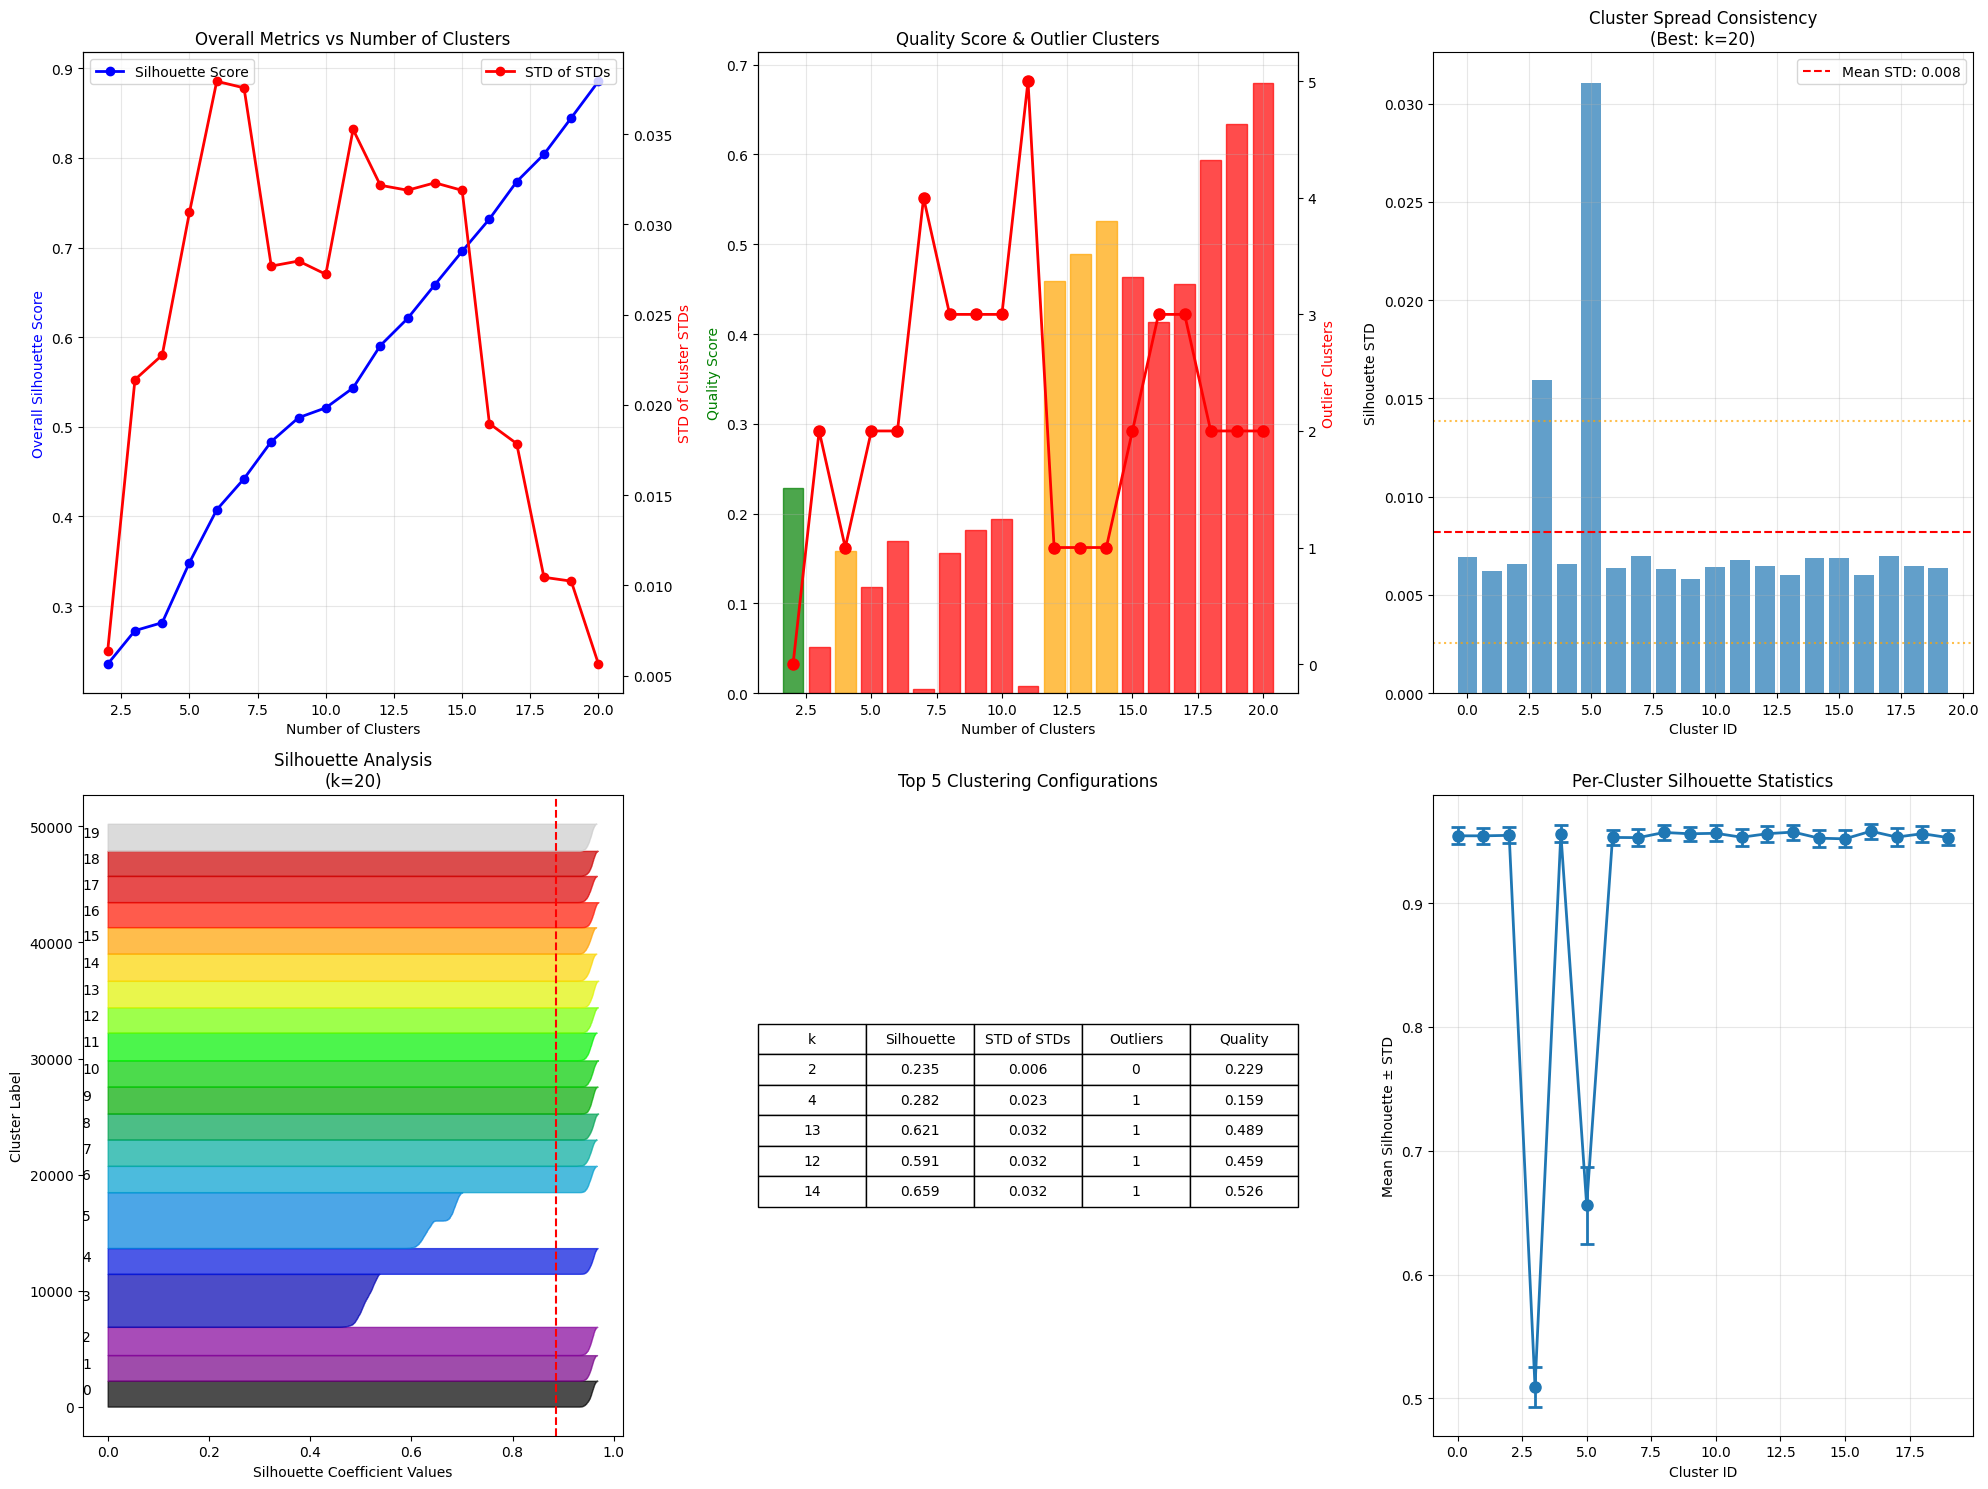


DETAILED SPREAD ANALYSIS REPORT

OPTIMAL CONFIGURATION:
Number of clusters: 20
Overall silhouette score: 0.8855
Quality score: 0.6799

SPREAD CONSISTENCY METRICS:
STD of cluster STDs: 0.0056
Mean of cluster STDs: 0.0082
Coefficient of variation (STDs): 0.6880
Number of outlier clusters: 2

PER-CLUSTER DETAILED STATISTICS:
--------------------------------------------------------------------------------
ID  Size   Mean     STD      Min      Max      Median  
--------------------------------------------------------------------------------
0   2222   0.954    0.007    0.931    0.968    0.956   
1   2200   0.954    0.006    0.930    0.967    0.955   
2   2423   0.955    0.007    0.929    0.967    0.956   
3   4555   0.509    0.016    0.454    0.537    0.509   
4   2213   0.956    0.007    0.929    0.968    0.957   
5   4803   0.656    0.031    0.586    0.701    0.668   
6   2260   0.953    0.006    0.932    0.966    0.954   
7   2255   0.953    0.007    0.925    0.966    0.954   
8   2227 

In [ ]:
UMAPSampler.plot_spread_analysis()

In [ ]:
UMAPSampler.cluster(n_clusters = 20)

Assigned cluster labels to 50027 samples
Silhouette Score: 0.8855


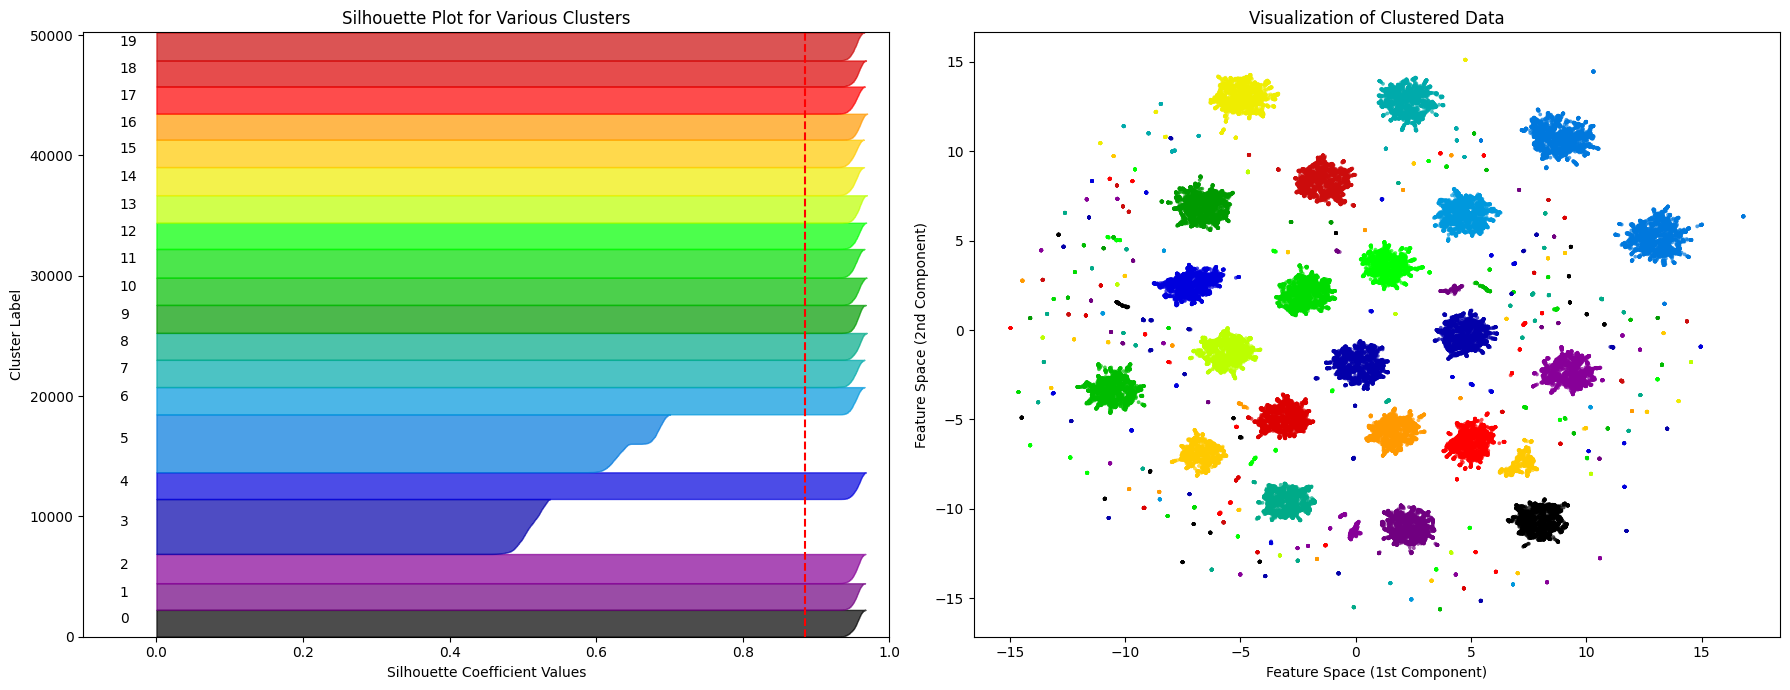

In [ ]:
UMAPSampler.plot_detailed_silhouette_analysis()

In [ ]:
sampled_df = UMAPSampler.sample_from_clusters(samples_per_cluster=1000)

Sampled 1000 items from cluster 0
Sampled 1000 items from cluster 1
Sampled 1000 items from cluster 2
Sampled 1000 items from cluster 3
Sampled 1000 items from cluster 4
Sampled 1000 items from cluster 5
Sampled 1000 items from cluster 6
Sampled 1000 items from cluster 7
Sampled 1000 items from cluster 8
Sampled 1000 items from cluster 9
Sampled 1000 items from cluster 10
Sampled 1000 items from cluster 11
Sampled 1000 items from cluster 12
Sampled 1000 items from cluster 13
Sampled 1000 items from cluster 14
Sampled 1000 items from cluster 15
Sampled 1000 items from cluster 16
Sampled 1000 items from cluster 17
Sampled 1000 items from cluster 18
Sampled 1000 items from cluster 19


In [ ]:
sampled_df.shape

(20000, 6)

In [ ]:
# Export
UMAPSampler.export_to_parquet(sampled_df, "sharegptv4_20k.parquet")

Exported sampled data to sharegptv4_20k.parquet


'sharegptv4_20k.parquet'

In [ ]:
parquet_url = UMAPSampler.upload_to_catbox("sharegptv4_20k.parquet")

Upload success: https://files.catbox.moe/wdlcqp.parquet


In [ ]:
parquet_url

'https://files.catbox.moe/wdlcqp.parquet'

In [ ]:
!wget {parquet_url}

--2025-06-01 04:16:43--  https://files.catbox.moe/wdlcqp.parquet
Resolving files.catbox.moe (files.catbox.moe)... 108.181.20.43
Connecting to files.catbox.moe (files.catbox.moe)|108.181.20.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10374451 (9.9M) [application/octet-stream]
Saving to: ‘wdlcqp.parquet’

wdlcqp.parquet      100%[===================>]   9.89M  18.6MB/s    in 0.5s    

2025-06-01 04:16:44 (18.6 MB/s) - ‘wdlcqp.parquet’ saved [10374451/10374451]



In [ ]:
from datasets import load_dataset

# Path ke file Parquet lokal
file_path = 'sharegptv4_20k.parquet'

# Load dataset langsung dari file Parquet
try:
    df = load_dataset("parquet", data_files=file_path, split="train")
    print("✅ File berhasil dimuat!ataset")
    print("🔹 Jumlah baris:", len(df))
    print("🔹 Kolom-kolom:", df.column_names)
except Exception as e:
    print("❌ Gagal memuat file:")
    print(e)


Generating train split: 0 examples [00:00, ? examples/s]

✅ File berhasil dimuat!ataset
🔹 Jumlah baris: 20000
🔹 Kolom-kolom: ['id', 'human_messages', 'assistant_messages', 'has_image', 'image_path', 'cluster']
